In [ ]:
ACCESS_TOKEN_HUGGINGFACE= "ur_token"

# Prepare data

In [1]:
!pip install kaggle-environments==1.14.14
!pip install evaluate
!pip install sentence-transformers==2.2.2
!pip install faiss-cpu
!pip install rouge_score
!pip install bert-score
!pip install trl==0.7.4
!pip install transformers==4.31.0
# !pip install langdetect

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.3/1.3 MB 16.8 MB/s eta 0:00:0000:010:01
  Attempting uninstall: kaggle-environments
    Found existing installation: kaggle-environments 1.14.15
    Uninstalling kaggle-environments-1.14.15:
      Successfully uninstalled kaggle-environments-1.14.15
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 84.0/84.0 kB 2.4 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 86.0/86.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125924 sha256=59b935d35b9ce9f99610865842f2c8eed3c89653e1b1c69fffa69305cfb35845
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910

In [2]:
import trl
import transformers
import sentence_transformers
print("Transformers version:", transformers.__version__)
print("TRL version:", trl.__version__)
print("sentence_transformers version:", sentence_transformers.__version__)

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


Transformers version: 4.31.0
TRL version: 0.7.4
sentence_transformers version: 2.2.2


In [3]:
import xml.etree.ElementTree as ET
from datasets import Dataset
import os

def process_xml_files(file_paths):
    """
    H√†m x·ª≠ l√Ω danh s√°ch file XML v√† tr·∫£ v·ªÅ Dataset ch·ª©a c√°c c·∫∑p c√¢u h·ªèi v√† c√¢u tr·∫£ l·ªùi.
    
    Args:
        file_paths (list of str): Danh s√°ch c√°c ƒë∆∞·ªùng d·∫´n t·ªõi file XML.
    
    Returns:
        Dataset: Dataset ch·ª©a c√°c c·∫∑p c√¢u h·ªèi v√† c√¢u tr·∫£ l·ªùi.
    """
    data = []

    for file_path in file_paths:
        try:
            tree = ET.parse(file_path)
            root = tree.getroot()

            for conversation in root.findall("CONVERSATION"):
                # L·∫•y thu·ªôc t√≠nh c·ªßa CONVERSATION
                conversation_id = conversation.get("id", "N/A")
                article = conversation.get("article", "N/A")

                questions = [q.text.strip() for q in conversation.findall("QUESTIONS/QUESTION") if q.text]

                # print(f"\nProcessing CONVERSATION ID: {conversation_id}, Article: {article}")

                for answer in conversation.findall("ANSWERS/ANSWER"):
                    answer_text = answer.text.strip() if answer.text else ""
                    answer_clause = answer.get("clause", "N/A")  # L·∫•y thu·ªôc t√≠nh clause trong ANSWER
                    answer_point = answer.get("point", "N/A")  # L·∫•y thu·ªôc t√≠nh point trong ANSWER
                    
                    # Ki·ªÉm tra n·∫øu answer kh√¥ng b·∫Øt ƒë·∫ßu b·∫±ng "ƒêi·ªÅu", "Kho·∫£n" ho·∫∑c "Theo"
                    if not answer_text.startswith(("ƒêi·ªÅu", "Kho·∫£n", "Theo")):
                        if article != "N/A":
                            if answer_clause != "N/A":
                                if answer_point != "N/A":
                                    answer_text = f"Theo ƒëi·ªÉm {answer_point}, kho·∫£n {answer_clause}, ƒëi·ªÅu {article}, {answer_text}"
                                else:
                                    answer_text = f"Theo kho·∫£n {answer_clause}, ƒëi·ªÅu {article}, {answer_text}"
                            else:
                                answer_text = f"Theo ƒëi·ªÅu {article}, {answer_text}"
                        else:
                            answer_text = f"Theo B·ªô Lu·∫≠t D√¢n S·ª± 2015, {answer_text}"
                    
                    # # In th√¥ng tin m·ªói c√¢u tr·∫£ l·ªùi m·ªôt l·∫ßn
                    # print(f" ‚Üí ANSWER: {answer_text}, Clause: {answer_clause}, Point: {answer_point}")
                    
                    for question in questions:
                        data.append({
                            "conversation_id": conversation_id,
                            "article": article,
                            "clause": answer_clause,  # Thu·ªôc t√≠nh clause t·ª´ ANSWER
                            "point": answer_point,  # Thu·ªôc t√≠nh point t·ª´ ANSWER
                            "question": question,
                            "answer": answer_text  # C√¢u tr·∫£ l·ªùi ƒë√£ ƒë∆∞·ª£c ch·ªânh s·ª≠a n·∫øu c·∫ßn
                        })

        except ET.ParseError:
            print(f"L·ªói ph√¢n t√≠ch c√∫ ph√°p XML: {file_path}")
        except Exception as e:
            print(f"L·ªói kh√¥ng x√°c ƒë·ªãnh v·ªõi file {file_path}: {e}")

    return Dataset.from_list(data) if data else None

# ƒê·ªçc danh s√°ch file XML
folder_path = "/kaggle/input/xml-data-luat-qa"
xml_files = [os.path.join(root, file) for root, _, files in os.walk(folder_path) for file in files if file.endswith(".xml")]

# T·∫°o Dataset
dataset = process_xml_files(xml_files)

In [4]:
dataset[10:15]

{'conversation_id': ['2', '2', '3', '3', '3'],
 'article': ['579', '579', '580', '580', '580'],
 'clause': ['2', '2', '1', '1', '1'],
 'point': ['N/A', 'N/A', 'N/A', 'N/A', 'N/A'],
 'question': ['Nh·∫∑t ƒë∆∞·ª£c ti·ªÅn m√† kh√¥ng tr·∫£ th√¨ c√≥ sao kh√¥ng?',
  'Nghƒ©a v·ª• ho√†n tr·∫£ khi ƒë∆∞·ª£c l·ª£i v·ªÅ t√†i s·∫£n m√† kh√¥ng c√≥ cƒÉn c·ª© ph√°p lu·∫≠t ƒë∆∞·ª£c quy ƒë·ªãnh nh∆∞ th·∫ø n√†o?',
  'Ph·∫£i tr·∫£ l·∫°i nh·ªØng g√¨ khi chi·∫øm gi·ªØ ho·∫∑c s·ª≠ d·ª•ng t√†i s·∫£n kh√¥ng c√≥ cƒÉn c·ª© ph√°p lu·∫≠t?',
  'N·∫øu chi·∫øm ƒë·ªì c·ªßa ng∆∞·ªùi kh√°c th√¨ ph·∫£i tr·∫£ l·∫°i nh·ªØng g√¨?',
  'T√†i s·∫£n ho√†n tr·∫£ trong tr∆∞·ªùng h·ª£p chi·∫øm h·ªØu, s·ª≠ d·ª•ng kh√¥ng c√≥ cƒÉn c·ª© ph√°p lu·∫≠t ƒë∆∞·ª£c quy ƒë·ªãnh nh∆∞ th·∫ø n√†o?'],
 'answer': ['Theo kho·∫£n 2, ƒëi·ªÅu 579, N·∫øu b·∫°n ƒë∆∞·ª£c h∆∞·ªüng l·ª£i v·ªÅ t√†i s·∫£n m√† kh√¥ng c√≥ cƒÉn c·ª© ph√°p lu·∫≠t v√† vi·ªác n√†y g√¢y thi·ªát h·∫°i cho ng∆∞·ªùi kh√°c, b·∫°n ph·∫£i ho√†n tr·∫£ kho·∫£n l·ª£i ƒë√≥ cho ng∆∞·ªùi b·ªã 

S·ªë l∆∞·ª£ng gi√° tr·ªã tr·ªëng trong t·∫≠p hu·∫•n luy·ªán:
 conversation_id    0
article            0
clause             0
point              0
question           0
answer             0
dtype: int64
S·ªë l∆∞·ª£ng gi√° tr·ªã tr·ªëng trong t·∫≠p ki·ªÉm th·ª≠:
 conversation_id    0
article            0
clause             0
point              0
question           0
answer             0
dtype: int64
Th√¥ng tin v·ªÅ t·∫≠p hu·∫•n luy·ªán:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8856 entries, 0 to 8855
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   conversation_id  8856 non-null   object
 1   article          8856 non-null   object
 2   clause           8856 non-null   object
 3   point            8856 non-null   object
 4   question         8856 non-null   object
 5   answer           8856 non-null   object
dtypes: object(6)
memory usage: 415.2+ KB
None

Th·ªëng k√™ c∆° b·∫£n (c·ªôt s·ªë):
       conve

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


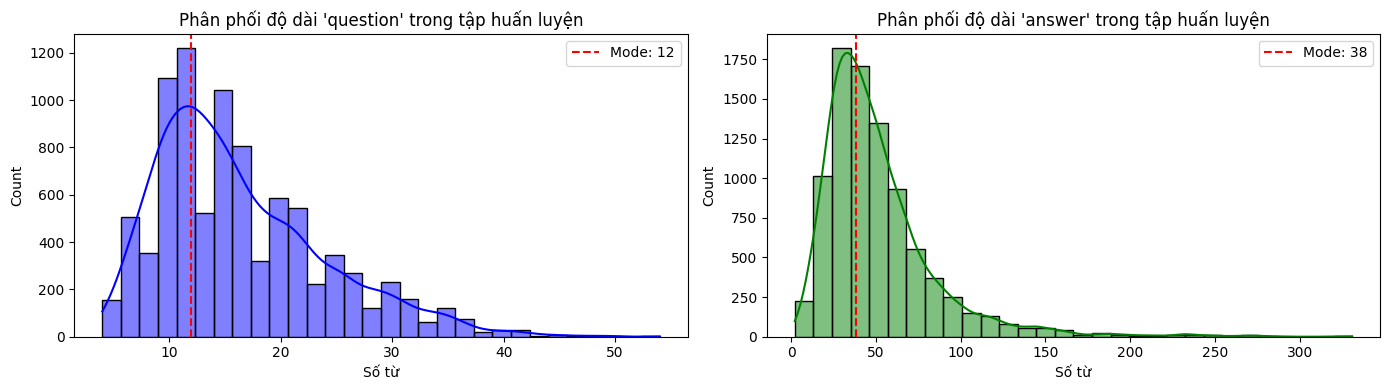

In [5]:
import asyncio
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
import torch
import os
import faiss
import pandas as pd
import evaluate
import random
import shutil
from sentence_transformers import SentenceTransformer
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.amp import autocast, GradScaler
import re
# from langdetect import detect
from tqdm import tqdm
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM,
    AutoModelForSequenceClassification,
    DataCollatorForSeq2Seq,
    GenerationConfig,
    EarlyStoppingCallback,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)
from trl import (
    PPOConfig, 
    PPOTrainer,
    AutoModelForSeq2SeqLMWithValueHead,
    create_reference_model
)

# C·∫•u h√¨nh thi·∫øt b·ªã v√† bi·∫øn m√¥i tr∆∞·ªùng cho multi-GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"  # S·ª≠ d·ª•ng 2 GPU ƒë·∫ßu ti√™n
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ƒê·ªçc file CSV v√†o Dataset
# dataset = Dataset.from_csv("/kaggle/input/data-luat-qa/data_luat.csv")

# T√°ch train v√† test
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Ch·ªçn m·ªôt l∆∞·ª£ng m·∫´u c·ª• th·ªÉ cho train v√† eval dataset
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

# Chuy·ªÉn ƒë·ªïi d·ªØ li·ªáu th√†nh DataFrame ƒë·ªÉ d·ªÖ x·ª≠ l√Ω
train_df = pd.DataFrame(train_dataset)
eval_df = pd.DataFrame(eval_dataset)

# Ki·ªÉm tra l·∫°i s·ªë l∆∞·ª£ng gi√° tr·ªã tr·ªëng tr∆∞·ªõc khi x·ª≠ l√Ω
print("S·ªë l∆∞·ª£ng gi√° tr·ªã tr·ªëng trong t·∫≠p hu·∫•n luy·ªán:\n", train_df.isnull().sum())
print("S·ªë l∆∞·ª£ng gi√° tr·ªã tr·ªëng trong t·∫≠p ki·ªÉm th·ª≠:\n", eval_df.isnull().sum())

# Hi·ªÉn th·ªã th√¥ng tin c∆° b·∫£n c·ªßa t·∫≠p d·ªØ li·ªáu
print("Th√¥ng tin v·ªÅ t·∫≠p hu·∫•n luy·ªán:")
print(train_df.info())

# Th·ªëng k√™ c∆° b·∫£n c·ªßa c√°c c·ªôt s·ªë
print("\nTh·ªëng k√™ c∆° b·∫£n (c·ªôt s·ªë):")
print(train_df.describe())

# T√≠nh ƒë·ªô d√†i c·ªßa c√¢u h·ªèi v√† c√¢u tr·∫£ l·ªùi
train_df['question_length'] = train_df['question'].apply(lambda x: len(x.split()) if x is not None else 0)
train_df['answer_length'] = train_df['answer'].apply(lambda x: len(x.split()) if x is not None else 0)

# T√≠nh gi√° tr·ªã mode (gi√° tr·ªã c√≥ t·∫ßn su·∫•t cao nh·∫•t)
question_mode = train_df['question_length'].mode()[0]
answer_mode = train_df['answer_length'].mode()[0]

# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(14, 4))

# Bi·ªÉu ƒë·ªì ph√¢n ph·ªëi ƒë·ªô d√†i c√¢u h·ªèi
plt.subplot(1, 2, 1)
sns.histplot(train_df['question_length'], kde=True, color="blue", bins=30)
plt.title("Ph√¢n ph·ªëi ƒë·ªô d√†i 'question' trong t·∫≠p hu·∫•n luy·ªán")
plt.xlabel("S·ªë t·ª´")
plt.axvline(question_mode, color='red', linestyle='--', label=f'Mode: {question_mode}')
plt.legend()

# Bi·ªÉu ƒë·ªì ph√¢n ph·ªëi ƒë·ªô d√†i c√¢u tr·∫£ l·ªùi
plt.subplot(1, 2, 2)
sns.histplot(train_df['answer_length'], kde=True, color="green", bins=30)
plt.title("Ph√¢n ph·ªëi ƒë·ªô d√†i 'answer' trong t·∫≠p hu·∫•n luy·ªán")
plt.xlabel("S·ªë t·ª´")
plt.axvline(answer_mode, color='red', linestyle='--', label=f'Mode: {answer_mode}')
plt.legend()

# Hi·ªÉn th·ªã c√°c bi·ªÉu ƒë·ªì
plt.tight_layout()
plt.show()


10 t·ª´ ph·ªï bi·∫øn nh·∫•t trong 'question':
[('c√≥', 3672), ('ƒë∆∞·ª£c', 3262), ('ng∆∞·ªùi', 2773), ('ƒë·ªãnh', 2588), ('th·∫ø', 2294), ('th√¨', 2219), ('c·ªßa', 2149), ('lu·∫≠t', 2097), ('n√†o', 2045), ('ƒêi·ªÅu', 2017)]


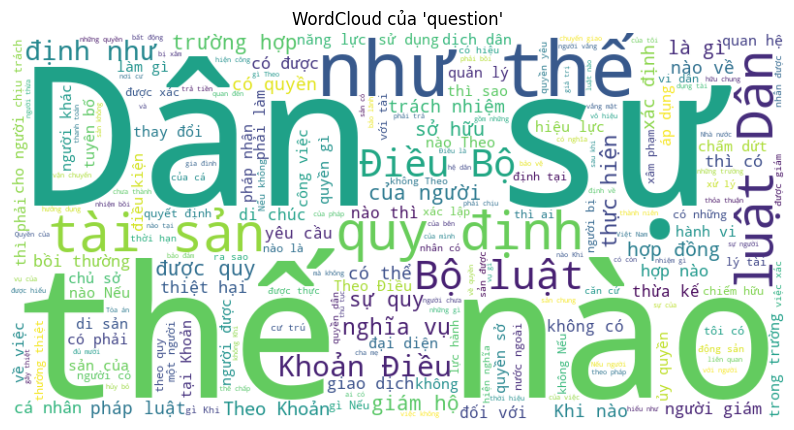

In [6]:
from collections import Counter
from wordcloud import WordCloud

# G·ªôp t·∫•t c·∫£ vƒÉn b·∫£n trong c·ªôt question
all_words = ' '.join(train_df['question'])
word_freq = Counter(all_words.split())

# Hi·ªÉn th·ªã t·ª´ ph·ªï bi·∫øn nh·∫•t
print("\n10 t·ª´ ph·ªï bi·∫øn nh·∫•t trong 'question':")
print(word_freq.most_common(10))

# Tr·ª±c quan h√≥a b·∫±ng WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_words)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud c·ªßa 'question'")
plt.show()


Trung b√¨nh ƒë·ªô d√†i c√¢u tr·∫£ l·ªùi theo nh√≥m ƒë·ªô d√†i c√¢u h·ªèi:
question_length_group
R·∫•t ng·∫Øn     51.075333
Ng·∫Øn        134.000000
V·ª´a                NaN
D√†i                NaN
Name: answer_length, dtype: float64


/tmp/ipykernel_30/291090372.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_analysis = train_df.groupby('question_length_group')['answer_length'].mean()


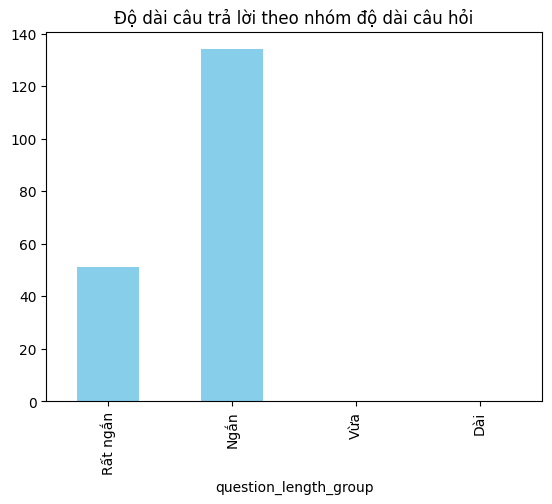

In [7]:
# Ph√¢n nh√≥m d·ª±a tr√™n ƒë·ªô d√†i c√¢u h·ªèi
train_df['question_length_group'] = pd.cut(train_df['question_length'], bins=[0, 50, 100, 150, 200], 
                                           labels=['R·∫•t ng·∫Øn', 'Ng·∫Øn', 'V·ª´a', 'D√†i'])

# Trung b√¨nh ƒë·ªô d√†i c√¢u tr·∫£ l·ªùi theo nh√≥m
group_analysis = train_df.groupby('question_length_group')['answer_length'].mean()
print("\nTrung b√¨nh ƒë·ªô d√†i c√¢u tr·∫£ l·ªùi theo nh√≥m ƒë·ªô d√†i c√¢u h·ªèi:")
print(group_analysis)

# Tr·ª±c quan h√≥a
group_analysis.plot(kind='bar', color='skyblue', title='ƒê·ªô d√†i c√¢u tr·∫£ l·ªùi theo nh√≥m ƒë·ªô d√†i c√¢u h·ªèi')
plt.show()

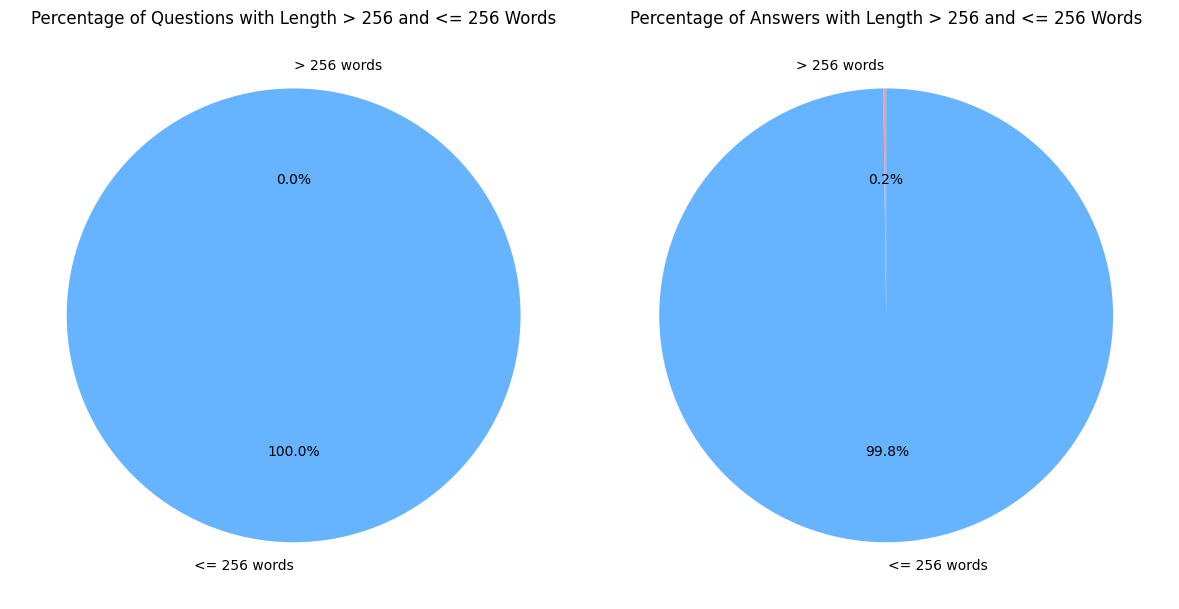

In [8]:
# Thay ƒë·ªïi ng∆∞·ª°ng n·∫øu c·∫ßn
threshold = 256

# ƒê·∫øm s·ªë l∆∞·ª£ng c√¢u h·ªèi c√≥ ƒë·ªô d√†i l·ªõn h∆°n ng∆∞·ª°ng
num_questions_over_threshold = train_df['question_length'].gt(threshold).sum()

# ƒê·∫øm s·ªë l∆∞·ª£ng c√¢u tr·∫£ l·ªùi c√≥ ƒë·ªô d√†i l·ªõn h∆°n ng∆∞·ª°ng
num_answers_over_threshold = train_df['answer_length'].gt(threshold).sum()

# ƒê·∫øm t·ªïng s·ªë c√¢u h·ªèi v√† c√¢u tr·∫£ l·ªùi
total_questions = len(train_df)
total_answers = len(train_df['answer'])

# T√≠nh t·ª∑ l·ªá ph·∫ßn trƒÉm c√¢u h·ªèi v√† c√¢u tr·∫£ l·ªùi c√≥ ƒë·ªô d√†i l·ªõn h∆°n ng∆∞·ª°ng
percentage_questions_over_threshold = (num_questions_over_threshold / total_questions) * 100
percentage_answers_over_threshold = (num_answers_over_threshold / total_answers) * 100

# T√≠nh t·ª∑ l·ªá ph·∫ßn trƒÉm c√¢u h·ªèi v√† c√¢u tr·∫£ l·ªùi c√≥ ƒë·ªô d√†i nh·ªè h∆°n ho·∫∑c b·∫±ng ng∆∞·ª°ng
percentage_questions_under_threshold = 100 - percentage_questions_over_threshold
percentage_answers_under_threshold = 100 - percentage_answers_over_threshold

# D·ªØ li·ªáu cho bi·ªÉu ƒë·ªì h√¨nh tr√≤n
question_data = [percentage_questions_over_threshold, percentage_questions_under_threshold]
answer_data = [percentage_answers_over_threshold, percentage_answers_under_threshold]

# T·∫°o bi·ªÉu ƒë·ªì h√¨nh tr√≤n cho c√¢u h·ªèi
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(question_data, labels=[f'> {threshold} words', f'<= {threshold} words'], autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.title(f'Percentage of Questions with Length > {threshold} and <= {threshold} Words')

# T·∫°o bi·ªÉu ƒë·ªì h√¨nh tr√≤n cho c√¢u tr·∫£ l·ªùi
plt.subplot(1, 2, 2)
plt.pie(answer_data, labels=[f'> {threshold} words', f'<= {threshold} words'], autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.title(f'Percentage of Answers with Length > {threshold} and <= {threshold} Words')

# Hi·ªÉn th·ªã bi·ªÉu ƒë·ªì
plt.tight_layout()
plt.show()

In [9]:
# Hi·ªÉn th·ªã m·ªôt v√†i m·∫´u d·ªØ li·ªáu
print("\nM·ªôt v√†i m·∫´u d·ªØ li·ªáu trong t·∫≠p hu·∫•n luy·ªán:")
train_df.sample(5)


M·ªôt v√†i m·∫´u d·ªØ li·ªáu trong t·∫≠p hu·∫•n luy·ªán:


conversation_id article clause point  \
2506              11       9    N/A   N/A   
6153             121     482      4   N/A   
8238              86      33      2   N/A   
1544              10     615      3   N/A   
759               13     577      2   N/A   

                                               question  \
2506    ƒêi·ªÅu 9 ƒë·ªÅ c·∫≠p ƒë·∫øn c√°ch th·ª©c th·ª±c hi·ªán quy·ªÅn g√¨?   
6153                 N·∫øu tr·∫£ ch·∫≠m t√†i s·∫£n thu√™ th√¨ sao?   
8238  Tr√°ch nhi·ªám c·ªßa c∆° s·ªü kh√°m b·ªánh, ch·ªØa b·ªánh tro...   
1544  Tr∆∞·ªùng h·ª£p di s·∫£n ƒë√£ ƒë∆∞·ª£c chia th√¨ nghƒ©a v·ª• t√†...   
759   M·ª©c b·ªìi th∆∞·ªùng thi·ªát h·∫°i c·ªßa ng∆∞·ªùi th·ª±c hi·ªán c...   

                                                 answer  question_length  \
2506    ƒêi·ªÅu 9 quy ƒë·ªãnh v·ªÅ vi·ªác th·ª±c hi·ªán quy·ªÅn d√¢n s·ª±.               11   
6153  Theo kho·∫£n 4, ƒëi·ªÅu 482, Khi b√™n thu√™ tr·∫£ ch·∫≠m ...                8   
8238  Theo kho·∫£n 2, ƒëi·ªÅu 33, quy ƒë·ªãnh tr√°ch nhi·ªám c·ª©...               36   
1544  Theo kho·∫£n 3 ƒêi·ªÅu 615 B·ªô lu·∫≠t D√¢n s·ª± 2015, tr∆∞...               23   
759   Theo kho·∫£n 2, ƒëi·ªÅu 577, quy ƒë·ªãnh n·∫øu ng∆∞·ªùi th·ª±...               28   

      answer_length question_length_group  
2506             11              R·∫•t ng·∫Øn  
6153             47              R·∫•t ng·∫Øn  
8238             33              R·∫•t ng·∫Øn  
1544             53              R·∫•t ng·∫Øn  
759              49              R·∫•t ng·∫Øn

# Preprocess Data

In [ ]:
# Kh·ªüi t·∫°o model v√† tokenizer v·ªõi 'mt5-base'
model_name = "sunbv56/ViLawT5_QAChatBot"
# model_name = "/kaggle/input/vilawt5_model/transformers/default/1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer
# Chuy·ªÉn DataFrame th√†nh dataset c·ªßa Hugging Face
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

# Ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu
def preprocess_data(example):
    # input_text = "c√¢u_h·ªèi" + example["question"]
    input_text = "c√¢u_h·ªèi" + example["question"]
    target_text = "tr·∫£_l·ªùi" + example["answer"]
    
    # √Åp d·ª•ng padding v√† truncation v·ªõi max_length th√≠ch h·ª£p
    input_encodings = tokenizer(input_text, 
                                truncation=True,
                                return_attention_mask=True, 
                                add_special_tokens=True, 
                                padding="max_length", 
                                max_length=256)
    target_encodings = tokenizer(target_text,
                                 truncation=True,
                                 padding="max_length",
                                 max_length=256)  # Gi·ªØ max_length cho target
    
    # Labels: thay th·∫ø pad token b·∫±ng -100 (t∆∞∆°ng th√≠ch v·ªõi m√¥ h√¨nh T5)
    labels = target_encodings["input_ids"]
    # labels = [-100 if label == tokenizer.pad_token_id else label for label in labels]  # Thay th·∫ø pad token b·∫±ng -100

    return {
        "input_ids": torch.tensor(input_encodings["input_ids"]),
        "attention_mask": torch.tensor(input_encodings["attention_mask"]),
        "labels": torch.tensor(labels)
    }

# √Åp d·ª•ng ti·ªÅn x·ª≠ l√Ω v√† x√≥a c√°c c·ªôt c≈©
train_dataset = train_dataset.map(preprocess_data, remove_columns=train_dataset.column_names)
eval_dataset = eval_dataset.map(preprocess_data, remove_columns=eval_dataset.column_names)
# train_dataset = train_dataset.map(preprocess_data)
# eval_dataset = eval_dataset.map(preprocess_data)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.29k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/75.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Map:   0%|          | 0/8856 [00:00<?, ? examples/s]

Map:   0%|          | 0/2215 [00:00<?, ? examples/s]

In [ ]:
# Ki·ªÉm tra l·∫°i c√°c c·ªôt trong dataset
print(train_dataset.column_names)  # Ch·ªâ c√≤n c√°c c·ªôt 'title', 'question', 'answer'
print(eval_dataset.column_names)   # Ki·ªÉm tra t·∫≠p eval

['input_ids', 'attention_mask', 'labels']
['input_ids', 'attention_mask', 'labels']


In [12]:
# H√†m gi·∫£i m√£
def decode_data(preprocessed):
    decoded_input = tokenizer.decode(preprocessed["input_ids"], skip_special_tokens=True)
    decoded_labels = tokenizer.decode(
        preprocessed["labels"],
        # [label for label in preprocessed["labels"] if label != -100],  # B·ªè qua -100
        skip_special_tokens=True
    )
    return {
        "decoded_input": decoded_input,
        "decoded_labels": decoded_labels,
    }

# V√≠ d·ª• c√¢u h·ªèi ti·∫øng Vi·ªát
example = {
    "question": train_df.iloc[0]['question'],
    "answer": train_df.iloc[0]['answer']
}

# Ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu
preprocessed = preprocess_data(example)

# Gi·∫£i m√£ d·ªØ li·ªáu
decoded = decode_data(preprocessed)

print("Ori data:")
print(train_df.iloc[0])
print("Preprocessed Data:")
print(preprocessed)
print("\nDecoded Data:")
print(decoded)

Ori data:
conversation_id                                                          3
article                                                                656
clause                                                                   2
point                                                                  N/A
question                 Th·ªèa thu·∫≠n c·ªßa nh·ªØng ng∆∞·ªùi th·ª´a k·∫ø ph·∫£i ƒë∆∞·ª£c l...
answer                          Theo kho·∫£n 2, ƒëi·ªÅu 656, L·∫≠p th√†nh vƒÉn b·∫£n.
question_length                                                         13
answer_length                                                            9
question_length_group                                             R·∫•t ng·∫Øn
Name: 0, dtype: object
Preprocessed Data:
{'input_ids': tensor([36096,  5269,  1276,    54,   204,    93,  1615,   949,   335,    74,
          650,   187,   482,   847, 35933,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,    

In [13]:
decode_data(train_dataset[312])

{'decoded_input': 'ƒêi·ªÅu 22 B·ªô lu·∫≠t D√¢n s·ª± quy ƒë·ªãnh nh∆∞ th·∫ø n√†o v·ªÅ vi·ªác tuy√™n b·ªë m·ªôt ng∆∞·ªùi m·∫•t nƒÉng l·ª±c h√†nh vi d√¢n s·ª±?',
 'decoded_labels': 'Theo ƒëi·ªÅu 22, B·ªô lu·∫≠t quy ƒë·ªãnh khi m·ªôt ng∆∞·ªùi do b·ªã b·ªánh t√¢m th·∫ßn ho·∫∑c m·∫Øc b·ªánh kh√°c m√† kh√¥ng th·ªÉ nh·∫≠n th·ª©c, l√†m ch·ªß ƒë∆∞·ª£c h√†nh vi th√¨ theo y√™u c·∫ßu c·ªßa ng∆∞·ªùi c√≥ quy·ªÅn, l·ª£i √≠ch li√™n quan ho·∫∑c c·ªßa c∆° quan, t·ªï ch·ª©c h·ªØu quan, T√≤a √°n ra quy·∫øt ƒë·ªãnh tuy√™n b·ªë ng∆∞·ªùi n√†y l√† ng∆∞·ªùi m·∫•t nƒÉng l·ª±c h√†nh vi d√¢n s·ª± tr√™n c∆° s·ªü k·∫øt lu·∫≠n gi√°m ƒë·ªãnh ph√°p y t√¢m th·∫ßn. Khi kh√¥ng c√≤n cƒÉn c·ª© tuy√™n b·ªë m·ªôt ng∆∞·ªùi m·∫•t nƒÉng l·ª±c h√†nh vi d√¢n s·ª± th√¨ theo y√™u c·∫ßu c·ªßa ch√≠nh ng∆∞·ªùi ƒë√≥ ho·∫∑c c·ªßa ng∆∞·ªùi c√≥ quy·ªÅn, l·ª£i √≠ch li√™n quan ho·∫∑c c·ªßa c∆° quan, t·ªï ch·ª©c h·ªØu quan, T√≤a √°n ra quy·∫øt ƒë·ªãnh h·ªßy b·ªè quy·∫øt ƒë·ªãnh tuy√™n b·ªë m·∫•t nƒÉng l·ª±c h√†nh vi d√¢n s·ª±. Giao d·ªãch d√¢

In [14]:
train_dataset[312]

{'input_ids': [36096,
  252,
  60,
  35852,
  656,
  710,
  1290,
  221,
  212,
  238,
  187,
  482,
  847,
  183,
  217,
  892,
  446,
  68,
  93,
  919,
  526,
  374,
  235,
  448,
  257,
  221,
  35933,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [15]:
print('input_ids:',len(train_dataset[0]['input_ids']))
print('attention_mask:',len(train_dataset[0]['attention_mask']))
print('labels:',len(train_dataset[0]['labels']))

input_ids: 256
attention_mask: 256
labels: 256


In [16]:
print("Length Train_Dataset:",len(train_dataset))
print("Length Eval_Dataset:",len(eval_dataset))

Length Train_Dataset: 8856
Length Eval_Dataset: 2215


In [17]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 8856
})

# RLHF

In [ ]:
# Thi·∫øt b·ªã
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model configurations
INITIAL_MODEL = "sunbv56/ViLawT5_QAChatBot"

# T·∫£i m√¥ h√¨nh ch√≠nh s√°ch (policy model) v√† tokenizer
policy_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(INITIAL_MODEL).to(device)
policy_tokenizer = AutoTokenizer.from_pretrained(INITIAL_MODEL)

# **T·∫°o m√¥ h√¨nh tham chi·∫øu (reference model) t·ª´ m√¥ h√¨nh ch√≠nh s√°ch**
policy_model_ref = create_reference_model(policy_model)

# T·∫£i m√¥ h√¨nh ph·∫ßn th∆∞·ªüng (reward model) v√† tokenizer
reward_model = AutoModelForSequenceClassification.from_pretrained("/kaggle/input/reward_model_01/transformers/default/1").to(device)
reward_tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/reward_model_01/transformers/default/1")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializ

In [33]:
policy_model_ref

AutoModelForSeq2SeqLMWithValueHead(
  (pretrained_model): T5ForConditionalGeneration(
    (shared): Embedding(36099, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(36099, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
     

In [ ]:
# H√†m t√≠nh ƒëi·ªÉm ph·∫ßn th∆∞·ªüng
def get_reward_scores(generated_texts, reward_model, reward_tokenizer):
    """Calculate reward scores using the reward model"""
    # L·∫•y clean_responses t·ª´ game_data v√† ƒë·∫£m b·∫£o n√≥ l√† danh s√°ch c√°c chu·ªói
    texts = generated_texts
    # N·∫øu texts l√† m·ªôt chu·ªói, chuy·ªÉn n√≥ th√†nh danh s√°ch chu·ªói
    if isinstance(texts, str):
        texts = [texts]
    # Tokenize c√°c vƒÉn b·∫£n
    inputs = reward_tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = reward_model(**inputs)
        scores = outputs.logits.squeeze().cpu().tolist()
    reward_tensors = [torch.tensor([score], dtype=torch.float32, device=device) for score in scores]

    return reward_tensors

In [35]:
train_dataset.set_format("torch")
eval_dataset.set_format("torch")

In [36]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 8856
})

In [37]:
import trl
print(trl.__version__)

0.7.4


In [40]:
batch_size = 32
n_step = int(len(train_dataset)/batch_size) # 8 batch_size
# C·∫•u h√¨nh PPO
ppo_config = PPOConfig(
    batch_size=batch_size,               # S·ªë m·∫´u trong m·ªôt batch ƒë∆∞·ª£c s·ª≠ d·ª•ng ƒë·ªÉ c·∫≠p nh·∫≠t m√¥ h√¨nh trong m·ªói b∆∞·ªõc hu·∫•n luy·ªán
    learning_rate=1.41e-5,      # T·ªëc ƒë·ªô h·ªçc (learning rate) cho thu·∫≠t to√°n t·ªëi ∆∞u h√≥a
    mini_batch_size=4,          # K√≠ch th∆∞·ªõc batch nh·ªè ƒë∆∞·ª£c s·ª≠ d·ª•ng trong m·ªôt l·∫ßn c·∫≠p nh·∫≠t (mini-batch gradient descent)
    optimize_cuda_cache=True,   # T·ªëi ∆∞u h√≥a vi·ªác s·ª≠ d·ª•ng b·ªô nh·ªõ CUDA tr√™n GPU
    gradient_accumulation_steps=2,  # S·ªë b∆∞·ªõc t√≠ch l≈©y gradient tr∆∞·ªõc khi th·ª±c hi·ªán m·ªôt l·∫ßn c·∫≠p nh·∫≠t tr·ªçng s·ªë
    early_stopping=True,        # D·ª´ng s·ªõm n·∫øu ƒëi·ªÅu ki·ªán h·ªôi t·ª• ƒë∆∞·ª£c ƒë√°p ·ª©ng
    target_kl=0.1,              # M·ª©c ƒë·ªô ph√¢n k·ª≥ KL (Kullback-Leibler divergence) m·ª•c ti√™u, gi√∫p ki·ªÉm so√°t ƒë·ªô ·ªïn ƒë·ªãnh c·ªßa hu·∫•n luy·ªán
    max_grad_norm=1.0,          # Gi√° tr·ªã chu·∫©n h√≥a t·ªëi ƒëa cho gradient ƒë·ªÉ tr√°nh gradient exploding
    seed=42,                    # Gi√° tr·ªã ng·∫´u nhi√™n ƒë∆∞·ª£c ƒë·∫∑t ƒë·ªÉ ƒë·∫£m b·∫£o t√≠nh t√°i l·∫∑p c·ªßa k·∫øt qu·∫£
    init_kl_coef=0.3,           # H·ªá s·ªë ban ƒë·∫ßu cho loss KL, gi√∫p ƒëi·ªÅu ch·ªânh s·ª± c√¢n b·∫±ng gi·ªØa ch√≠nh s√°ch hi·ªán t·∫°i v√† tham chi·∫øu
    steps=n_step,                  # S·ªë b∆∞·ªõc hu·∫•n luy·ªán trong m·ªói epoch
    ppo_epochs=3,               # S·ªë epoch (chu k·ª≥) hu·∫•n luy·ªán trong PPO
    cliprange=0.1,               # Gi√° tr·ªã c·∫Øt (clipping range) cho t·ª∑ l·ªá ch√≠nh s√°ch ƒë·ªÉ ngƒÉn overfitting
    remove_unused_columns = False
)

# Kh·ªüi t·∫°o data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=policy_tokenizer,
    model=policy_model,
    padding='max_length',  # Th√™m padding
    pad_to_multiple_of=True,  # Th√™m truncation
    max_length=256,  # Gi·ªõi h·∫°n chi·ªÅu d√†i t·ªëi ƒëa (n·∫øu c·∫ßn)
    return_tensors="pt",  # Tr·∫£ v·ªÅ tensors PyTorch
    label_pad_token_id=-100  # Padding cho labels
)

# Kh·ªüi t·∫°o PPOTrainer
ppo_trainer = PPOTrainer(
    config=ppo_config,          # C·∫•u h√¨nh PPO t·ª´ ppo_config
    model=policy_model,         # M√¥ h√¨nh ch√≠nh s√°ch ƒë∆∞·ª£c hu·∫•n luy·ªán
    ref_model=policy_model_ref, # M√¥ h√¨nh tham chi·∫øu ƒë·ªÉ t√≠nh to√°n loss KL v√† c·∫≠p nh·∫≠t ch√≠nh s√°ch
    tokenizer=policy_tokenizer, # Tokenizer ƒë·ªÉ x·ª≠ l√Ω d·ªØ li·ªáu
    dataset=train_dataset,      # B·ªô d·ªØ li·ªáu hu·∫•n luy·ªán
    data_collator=data_collator,# Data collator ƒë·ªÉ chu·∫©n b·ªã batch d·ªØ li·ªáu hu·∫•n luy·ªán
)

In [42]:
res_df_csv=[]

In [ ]:
def generate_response(args):
    input_id, attention_mask, ppo_trainer = args
    response = ppo_trainer.generate(
        input_id,
        attention_mask=attention_mask.unsqueeze(0),
        max_new_tokens=512,
    )
    return response

def process_batch_parallel(batch, ppo_trainer, policy_tokenizer, device, 
                         bleu_metric=None, rouge_metric=None, bertscore_metric=None, max_workers=4):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    
    # Chu·∫©n b·ªã arguments cho parallel processing
    generate_args = [(input_ids[i], attention_mask[i], ppo_trainer) 
                    for i in range(len(input_ids))]
    
    # Ch·∫°y song song vi·ªác generate responses
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        generated_responses = list(executor.map(generate_response, generate_args))
    
    # X·ª≠ l√Ω k·∫øt qu·∫£
    query_tensors = [input_ids[i] for i in range(len(input_ids))]
    
    # Chuy·ªÉn ƒë·ªïi tensor th√†nh text song song
    def decode_response(response):
        return policy_tokenizer.decode(response.squeeze(0).tolist(), 
                                     skip_special_tokens=True)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        generated_texts = list(executor.map(decode_response, generated_responses))
    
    # Tokenize responses song song
    def tokenize_text(text):
        tokens = policy_tokenizer(
            text, 
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            padding="max_length",
            max_length=256
        )
        return torch.tensor(tokens['input_ids'], dtype=torch.long, device=device)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        response_tensors = list(executor.map(tokenize_text, generated_texts))
    
    # Decode target texts song song
    target_texts = [
        policy_tokenizer.decode(target_tensor.squeeze(0).tolist(), 
                              skip_special_tokens=True)
        for target_tensor in batch["labels"]
    ]   
    
    question_texts = [
        policy_tokenizer.decode(ques_tensor.squeeze(0).tolist(), 
                              skip_special_tokens=True)
        for ques_tensor in batch["input_ids"]
    ]   
    
    # T√≠nh rewards
    if (bleu_metric==None or rouge_metric==None or bertscore_metric==None):
        rewards = get_reward_scores(generated_texts, reward_model, reward_tokenizer)
    else:
        rewards = get_reward_scores(
            generated_texts,
            target_texts,
            bleu_metric,
            rouge_metric,
            bertscore_metric
        )
    
    return query_tensors, response_tensors, rewards, generated_texts, target_texts, question_texts

# V√≤ng l·∫∑p hu·∫•n luy·ªán ch√≠nh
def train_ppo_parallel(ppo_trainer, ppo_config, policy_model, policy_tokenizer,
                      device, bleu_metric=None, rouge_metric=None, bertscore_metric=None):
    for epoch in range(ppo_config.ppo_epochs):
        print(f"\nEpoch {epoch + 1}/{ppo_config.ppo_epochs}")
        
        for step in tqdm(range(ppo_config.steps), desc=f"Training"):
            # L·∫•y batch t·ª´ dataloader
            batch = next(iter(ppo_trainer.dataloader))
            if (bleu_metric==None or rouge_metric==None or bertscore_metric==None):
                # X·ª≠ l√Ω batch song song
                query_tensors, response_tensors, rewards, generated_texts, target_texts, question_texts = \
                    process_batch_parallel(
                        batch, ppo_trainer, policy_tokenizer, device
                    )
            else:
                # X·ª≠ l√Ω batch song song
                query_tensors, response_tensors, rewards, generated_texts, target_texts, question_texts = \
                    process_batch_parallel(
                        batch, ppo_trainer, policy_tokenizer, device,
                        bleu_metric, rouge_metric, bertscore_metric
                    )
            
            # C·∫≠p nh·∫≠t m√¥ h√¨nh v·ªõi PPO
            stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
            
            # Log stats sau m·ªói 5 b∆∞·ªõc
            if step % 5 == 0:
                print(f"\nStep {step}/{ppo_config.steps}")
                rewards_tensor = torch.stack(rewards)
                print(f"Average reward: {torch.mean(rewards_tensor):.3f}")
                
                for i in range(min(2, len(generated_texts))):
                    print(f"\nExample {i+1}:")
                    print(f"Generated: {generated_texts[i]}")
                    print(f"Target: {target_texts[i]}")
                    print(f"Reward: {rewards[i].item():.3f}")
                    
                for i in range(len(generated_texts)):
                    res_df_csv.append({
                        "conversation_id": i,
                        "article": "N\A",
                        "clause": "N\A",
                        "point": "N\A",
                        "question": question_texts[i],
                        "target_text": target_texts[i],
                        "generated_text": generated_texts[i],
                        "Legal Acc": rewards[i].item(),
                        "Relevance": rewards[i].item(),
                        "Fluency": rewards[i].item(),
                        "bleu_score": rewards[i].item(),
                        "rouge1_score": rewards[i].item(),
                        "rouge2_score": rewards[i].item(),
                        "rougeL_score": rewards[i].item(),
                        "rougeLsum_score": rewards[i].item()
                    })
                
                ppo_trainer.log_stats(stats, batch, rewards)
        
        # L∆∞u m√¥ h√¨nh sau m·ªói epoch
        save_dir = f"ppo_model_epoch_{epoch + 1}"
        os.makedirs(save_dir, exist_ok=True)
        policy_model.save_pretrained(save_dir)
        policy_tokenizer.save_pretrained(save_dir)
        print(f"\nSaved model for epoch {epoch + 1} at {save_dir}")

train_ppo_parallel(
    ppo_trainer=ppo_trainer,
    ppo_config=ppo_config,
    policy_model=policy_model,
    policy_tokenizer=policy_tokenizer,
    device=device,
)


Epoch 1/3


Training:   0%|          | 0/276 [00:00<?, ?it/s]You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1328: UserWarning: The game logs will not be logged because the batch does not contain the keys 'query' and 'response'. 
  warnings.warn(
Training:   0%|          | 1/276 [01:03<4:51:06, 63.52s/it]


Step 0/276
Average reward: 0.743

Example 1:
Generated: Theo kho·∫£n 1 ƒêi·ªÅu 540 B·ªô lu·∫≠t D√¢n s·ª± 2015, b√™n nh·∫≠n t√†i s·∫£n c√≥ quy·ªÅn ki·ªÉm tra s·ªë l∆∞·ª£ng, ch·∫•t l∆∞·ª£ng t√†i s·∫£n ƒë∆∞·ª£c v·∫≠n chuy·ªÉn ƒë·∫øn.
Target: Theo kho·∫£n 1, ƒëi·ªÅu 540, B√™n nh·∫≠n t√†i s·∫£n c√≥ quy·ªÅn ki·ªÉm tra s·ªë l∆∞·ª£ng v√† ch·∫•t l∆∞·ª£ng c·ªßa t√†i s·∫£n ƒë∆∞·ª£c v·∫≠n chuy·ªÉn ƒë·∫øn.
Reward: 0.810

Example 2:
Generated: Theo ƒêi·ªÅu 307, Sau khi tr·ª´ chi ph√≠, ti·ªÅn b√°n t√†i s·∫£n c·∫ßm c·ªë, th·∫ø ch·∫•p ƒë∆∞·ª£c thanh to√°n theo ƒêi·ªÅu 308 B·ªô lu·∫≠t D√¢n s·ª± 2015. S·ªë d∆∞ tr·∫£ cho b√™n b·∫£o ƒë·∫£m. N·∫øu kh√¥ng ƒë·ªß, ph·∫ßn c√≤n l·∫°i l√† nghƒ©a v·ª• kh√¥ng b·∫£o ƒë·∫£m (tr·ª´ khi c√≥ th·ªèa thu·∫≠n b·ªï sung) v√† b√™n nh·∫≠n b·∫£o ƒë·∫£m c√≥ th·ªÉ y√™u c·∫ßu thanh to√°n.
Target: Theo ƒêi·ªÅu 307 B·ªô lu·∫≠t D√¢n s·ª± 2015, sau khi tr·ª´ chi ph√≠, ti·ªÅn x·ª≠ l√Ω t√†i s·∫£n c·∫ßm c·ªë, th·∫ø ch·∫•p ƒë∆∞·ª£c thanh to√°n theo ƒêi·ªÅu 308 c·ªßa B·ªô lu·∫≠t n√†y. D∆

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (16.89) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (4920468.50) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (1038.69) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (341329824.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (29799.76) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: Th


Step 5/276
Average reward: 0.741

Example 1:
Generated: Theo ƒêi·ªÅu 610, C√° nh√¢n c√≥ quy·ªÅn l·∫≠p di ch√∫c ƒë·ªÉ ƒë·ªãnh ƒëo·∫°t t√†i s·∫£n, ƒë·ªÉ l·∫°i t√†i s·∫£n cho ng∆∞·ªùi th·ª´a k·∫ø theo ph√°p lu·∫≠t sau n√†y.
Target: Theo ƒêi·ªÅu 609 B·ªô lu·∫≠t D√¢n s·ª± 2015, c√° nh√¢n c√≥ quy·ªÅn l·∫≠p di ch√∫c ƒë·ªÉ ƒë·ªãnh ƒëo·∫°t t√†i s·∫£n, ƒë·ªÉ l·∫°i t√†i s·∫£n cho ng∆∞·ªùi th·ª´a k·∫ø theo ph√°p lu·∫≠t, h∆∞·ªüng di s·∫£n theo di ch√∫c ho·∫∑c theo ph√°p lu·∫≠t. Ng∆∞·ªùi th·ª´a k·∫ø kh√¥ng l√† c√° nh√¢n c√≥ quy·ªÅn h∆∞·ªüng di s·∫£n theo di ch√∫c.
Reward: 0.663

Example 2:
Generated: Theo kho·∫£n 1 ƒêi·ªÅu 444 B·ªô lu·∫≠t D√¢n s·ª± 2015, b√™n b√°n c√≥ nghƒ©a v·ª• b·∫£o ƒë·∫£m quy·ªÅn s·ªü h·ªØu t√†i s·∫£n cho b√™n mua kh√¥ng b·ªã ng∆∞·ªùi th·ª© ba tranh ch·∫•p.
Target: Theo kho·∫£n 1 ƒêi·ªÅu 444 B·ªô lu·∫≠t D√¢n s·ª± 2015, b√™n b√°n c√≥ nghƒ©a v·ª• b·∫£o ƒë·∫£m quy·ªÅn s·ªü h·ªØu ƒë·ªëi v·ªõi t√†i s·∫£n ƒë√£ b√°n cho b√™n mua kh√¥ng b·ªã ng∆∞·ªùi th·ª© ba tranh ch·∫•p.
Reward: 0.72

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (33.92) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -4298.08 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:   3%|‚ñé         | 7/276 [07:55<4:52:03, 65.14s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (64479.28) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (101.97) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/


Step 10/276
Average reward: 0.727

Example 1:
Generated: Theo ƒêi·ªÅu 672, quy ƒë·ªãnh v·ªÅ cƒÉn c·ª© x√°c ƒë·ªãnh ph√°p lu·∫≠t √°p d·ª•ng ƒë·ªëi v·ªõi ng∆∞·ªùi kh√¥ng qu·ªëc t·ªãch v√† ng∆∞·ªùi c√≥ nhi·ªÅu qu·ªëc t·ªãch trong c√°c quan h·ªá d√¢n s·ª± c√≥ y·∫øu t·ªë n∆∞·ªõc ngo√†i, ƒë∆∞·ª£c ph√°p lu·∫≠t √°p d·ª•ng khi h·∫≠u qu·∫£ c·ªßa vi·ªác kh√¥ng c√≥ qu·ªëc t·ªãch ti·∫øp t·ª•c ƒë∆∞·ª£c x√°c ƒë·ªãnh t·∫°i kho·∫£n 2 ƒêi·ªÅu n√†y.
Target: Theo ƒëi·ªÅu 672, quy ƒë·ªãnh v·ªÅ cƒÉn c·ª© x√°c ƒë·ªãnh ph√°p lu·∫≠t √°p d·ª•ng ƒë·ªëi v·ªõi ng∆∞·ªùi kh√¥ng qu·ªëc t·ªãch v√† ng∆∞·ªùi c√≥ nhi·ªÅu qu·ªëc t·ªãch trong c√°c quan h·ªá d√¢n s·ª± c√≥ y·∫øu t·ªë n∆∞·ªõc ngo√†i. ƒê·ªëi v·ªõi ng∆∞·ªùi kh√¥ng qu·ªëc t·ªãch, ph√°p lu·∫≠t √°p d·ª•ng l√† ph√°p lu·∫≠t c·ªßa n∆∞·ªõc n∆°i ng∆∞·ªùi ƒë√≥ c∆∞ tr√∫ ho·∫∑c c√≥ m·ªëi li√™n h·ªá g·∫Øn b√≥ nh·∫•t. ƒê·ªëi v·ªõi ng∆∞·ªùi c√≥ nhi·ªÅu qu·ªëc t·ªãch, ph√°p lu·∫≠t √°p d·ª•ng l√† ph√°p lu·∫≠t c·ªßa n∆∞·ªõc n∆°i ng∆∞·ªùi ƒë√≥ c√≥ qu·ªëc t·ªãch v√† c∆∞ tr√∫, ho

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (28.14) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (28.82) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (1438.83) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (1438.48) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (81075.01) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average 


Step 15/276
Average reward: 0.702

Example 1:
Generated: Theo Kho·∫£n 2, ƒêi·ªÅu 7, Ph·∫£i b·∫£o ƒë·∫£m gi·ªØ g√¨n b·∫£n s·∫Øc d√¢n t·ªôc, t√¥n tr·ªçng v√† ph√°t huy phong t·ª•c, t·∫≠p qu√°n, truy·ªÅn th·ªëng t·ªët ƒë·∫πp, t√¨nh ƒëo√†n k·∫øt, t∆∞∆°ng th√¢n, t∆∞∆°ng √°i, m·ªói ng∆∞·ªùi v√¨ c·ªông ƒë·ªìng, c·ªông ƒë·ªìng v√¨ m·ªói ng∆∞·ªùi v√† c√°c gi√° tr·ªã ƒë·∫°o ƒë·ª©c cao ƒë·∫πp c·ªßa c√°c d√¢n t·ªôc c√πng sinh s·ªëng t·∫°i ƒë·ªãa ƒëi·ªÉm v√† th·ªùi ƒëi·ªÉm ƒë·∫∑t ra ƒë·ªÅ ngh·ªã.
Target: Theo kho·∫£n 1, ƒëi·ªÅu 7, vi·ªác x√°c l·∫≠p, th·ª±c hi·ªán, ch·∫•m d·ª©t quy·ªÅn v√† nghƒ©a v·ª• d√¢n s·ª± ph·∫£i b·∫£o ƒë·∫£m gi·ªØ g√¨n b·∫£n s·∫Øc d√¢n t·ªôc, t√¥n tr·ªçng v√† ph√°t huy phong t·ª•c, t·∫≠p qu√°n, truy·ªÅn th·ªëng t·ªët ƒë·∫πp, t√¨nh ƒëo√†n k·∫øt, t∆∞∆°ng th√¢n, t∆∞∆°ng √°i.
Reward: 0.714

Example 2:
Generated: Theo Kho·∫£n 2, ƒêi·ªÅu 66√°p lu·∫≠t √Åp d·ª•ng ph√°p lu·∫≠t c·ªßa n∆∞·ªõc c√≥ m·ªëi li√™n h·ªá g·∫Øn b√≥ nh·∫•t v·ªõi quan h·ªá d√¢n s·ª± ƒë√≥.
Target: Theo kho·∫£n 3, ƒ

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -6160.63 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:   6%|‚ñå         | 17/276 [19:35<5:01:46, 69.91s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -7829.74 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:   7%|‚ñã         | 18/276 [20:34<4:47:21, 66.83s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is


Step 20/276
Average reward: 0.705

Example 1:
Generated: Theo ƒêi·ªÅu 277, ƒê·ªãa ƒëi·ªÉm th·ª±c hi·ªán nghƒ©a v·ª• theo th·ªèa thu·∫≠n, ho·∫∑c t·∫°i n∆°i c√≥ b·∫•t ƒë·ªông s·∫£n (n·∫øu nghƒ©a v·ª• li√™n quan ƒë·∫øn b·∫•t ƒë·ªông s·∫£n), ho·∫∑c t·∫°i n∆°i c√≥ b·∫•t ƒë·ªông s·∫£n (n·∫øu nghƒ©a v·ª• li√™n quan ƒë·∫øn b·∫•t ƒë·ªông s·∫£n) n·∫øu n∆°i ƒë√≥ l√† n∆°i ·ªü/tr·ª• s·ªü c·ªßa b√™n c√≥ quy·ªÅn. N·∫øu kh√¥ng c√≥ ho·∫∑c kh√¥ng (tr·ª´ khi lu·∫≠t), ho·∫∑c t·∫°i n∆°i kh√°c (tr·ª´ khi c√≥ th·ªèa thu·∫≠n kh√°c), ho·∫∑c t·∫°i n∆°i kh√°c (n·∫øu lu·∫≠t cho), ho·∫∑c t·∫°i n∆°i c√≥ b·∫•t ƒë·ªông s·∫£n (n·∫øu nghƒ©a v·ª• li√™n quan ƒë·∫øn b·∫•t ƒë·ªông s·∫£n), ho·∫∑c t·∫°i n∆°i c√≥ b·∫•t ƒë·ªông s·∫£n (n·∫øu nghƒ©a v·ª• li√™n quan ƒë·∫øn b·∫•t ƒë·ªông s·∫£n), ho·∫∑c t·∫°i n∆°i ·ªü/tr·ª• n·∫øu n∆°i ·ªü/tr·ª• s·ªü c·ªßa b√™n c√≥ quy·ªÅn.
Target: Theo ƒêi·ªÅu 277 B·ªô lu·∫≠t D√¢n s·ª± 2015, ƒë·ªãa ƒëi·ªÉm th·ª±c hi·ªán nghƒ©a v·ª• do c√°c b√™n th·ªèa thu·∫≠n. N·∫øu kh√¥ng th·ªèa thu·∫≠n, th·ª±c h

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -11308.41 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:   8%|‚ñä         | 22/276 [25:20<5:01:16, 71.17s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -13748.14 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:   8%|‚ñä         | 23/276 [26:38<5:09:11, 73.33s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ra


Step 25/276
Average reward: 0.704

Example 1:
Generated: Theo ƒêi·ªÅu 74, M·ªôt t·ªï ch·ª©c ƒë∆∞·ª£c coi l√† ph√°p nh√¢n khi ƒë∆∞·ª£c th√†nh l·∫≠p h·ª£p ph√°p, c√≥ c∆° quan nh√† n∆∞·ªõc (tr·ª´ khi c√≥ lu·∫≠t), c√≥ c∆° quan nh√† n∆∞·ªõc l√†m vi·ªác theo lu·∫≠t, ƒëƒÉng k√Ω thay c√¥ng d√¢n, ƒë·∫°i di·ªán khi t·ªï ch·ª©c kh√°c.
Target: Theo ƒêi·ªÅu 74 B·ªô lu·∫≠t D√¢n s·ª± 2015, m·ªôt t·ªï ch·ª©c ƒë∆∞·ª£c c√¥ng nh·∫≠n l√† ph√°p nh√¢n khi: ƒê∆∞·ª£c th√†nh l·∫≠p theo lu·∫≠t; C√≥ c∆° c·∫•u t·ªï ch·ª©c; C√≥ t√†i s·∫£n ƒë·ªôc l·∫≠p v√† t·ª± ch·ªãu tr√°ch nhi·ªám; Nh√¢n danh m√¨nh tham gia quan h·ªá ph√°p lu·∫≠t ƒë·ªôc l·∫≠p.
Reward: 0.820

Example 2:
Generated: Theo ƒêi·ªÅu 473, H·ª£p ƒë·ªìng thu√™ t√†i s·∫£n l√† th·ªèa thu·∫≠n gi·ªØa b√™n cho thu√™ v√† b√™n thu√™, theo ƒë√≥ b√™n cho thu√™ giao t√†i s·∫£n cho b√™n thu√™ ƒë·ªÉ s·ª≠ d·ª•ng trong m·ªôt kho·∫£ng th·ªùi gian nh·∫•t ƒë·ªãnh, v√† b√™n thu√™ ph·∫£i tr·∫£ ti·ªÅn thu√™ cho vi·ªác s·ª≠ d·ª•ng ƒë·ªëi v·ªõi t√†i s·∫£n ƒë√£ thu√™
Target: Th

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (13.25) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (17.84) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -15974.62 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  10%|‚ñâ         | 27/276 [31:42<5:15:05, 75.93s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -18939.39 - this might be a precursor for failed training. s


Step 30/276
Average reward: 0.469

Example 1:
Generated: Theo Kho·∫£n 1, ƒêi·ªÅu 6, quy ƒë·ªãnh ng∆∞·ªùi gi√°m h·ªô ƒë∆∞·ª£c thay ƒë·ªïi trong c√°c tr∆∞·ªùng: ng∆∞·ªùi gi√°m h·ªô c·ªßa ng∆∞·ªùi ch∆∞a th√†nh ni√™n, ng∆∞·ªùi m·∫•t nƒÉng l·ª±c h√†nh vi d√¢n s·ª±, c√≥ v·∫•n gi√°m h·ªô...
Target: Theo kho·∫£n 1, ƒëi·ªÅu 60, quy ƒë·ªãnh ng∆∞·ªùi gi√°m h·ªô ƒë∆∞·ª£c thay ƒë·ªïi trong c√°c tr∆∞·ªùng h·ª£p: kh√¥ng c√≤n ƒë·ªß ƒëi·ªÅu ki·ªán, ch·∫øt ho·∫∑c b·ªã T√≤a √°n tuy√™n b·ªë h·∫°n ch·∫ø nƒÉng l·ª±c h√†nh vi d√¢n s·ª±, m·∫•t nƒÉng l·ª±c h√†nh vi d√¢n s·ª±, m·∫•t t√≠ch, ph√°p nh√¢n ch·∫•m d·ª©t t·ªìn t·∫°i, vi ph·∫°m nghi√™m tr·ªçng nghƒ©a v·ª•, ƒë·ªÅ ngh·ªã thay ƒë·ªïi v√† c√≥ ng∆∞·ªùi kh√°c nh·∫≠n l√†m gi√°m h·ªô.
Reward: 0.740

Example 2:
Generated: Theo Kho·∫£n 4, ƒêi·ªÅu 26, c√° nh√¢n quy ƒë·ªãnh vi·ªác thay ƒë·ªïi h·ªç, t√™n trong quan h·ªá ph√°p lu·∫≠t d√¢n s·ª± c√≥ s·ª± tham gia c·ªßa c√° nh√¢n, vi·ªác c·ªßa c√°i, li√™n quan ƒë·∫øn h·ªç, t√™n c·ªßa c√°c th√†nh vi√™n kinh t·∫ø ƒë·ªÉ 

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -18189.03 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  12%|‚ñà‚ñè        | 32/276 [39:13<6:12:12, 91.53s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -22204.56 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  12%|‚ñà‚ñè        | 33/276 [40:50<6:17:59, 93.33s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL diverge


Step 35/276
Average reward: 0.501

Example 1:
Generated: Theo ƒêi·ªÅu 530 B·ªô lu·∫≠t D√¢n s·ª± 2015, h·ª£p ƒë·ªìng l√† s·ª± th·ªèa thu·∫≠n gi·ªØa c√°c b√™n v·∫≠n chuy·ªÉn t√†i s·∫£n, b√™n v·∫≠n chuy·ªÉn nh·∫≠n t√†i s·∫£n ƒë·ªÉ chuy·ªÉn quy·ªÅn s·ªü h·ªØu cho b√™n nh·∫≠n t√†i s·∫£n ƒë·ªÉ chuy·ªÉn ƒë·∫øn ƒë·ªãa ƒëi·ªÉm ƒë√£ th·ªèa c·ªßa h·ª£p ƒë·ªìng, sau khi nh·∫≠n t√†i s·∫£n.
Target: Theo ƒêi·ªÅu 530 B·ªô lu·∫≠t D√¢n s·ª± 2015, h·ª£p ƒë·ªìng v·∫≠n chuy·ªÉn t√†i s·∫£n l√† s·ª± th·ªèa thu·∫≠n gi·ªØa c√°c b√™n, theo ƒë√≥ b√™n v·∫≠n chuy·ªÉn c√≥ nghƒ©a v·ª• chuy·ªÉn t√†i s·∫£n ƒë·∫øn ƒë·ªãa ƒëi·ªÉm ƒë√£ ƒë·ªãnh theo th·ªèa thu·∫≠n v√† giao t√†i s·∫£n ƒë√≥ cho ng∆∞·ªùi c√≥ quy·ªÅn nh·∫≠n, b√™n thu√™ v·∫≠n chuy·ªÉn c√≥ nghƒ©a v·ª• tr·∫£ c∆∞·ªõc ph√≠ v·∫≠n chuy·ªÉn.
Reward: 0.809

Example 2:
Generated: Theo Kho·∫£n 2, ƒêi·ªÅu 228, B·∫°n ƒë∆∞·ª£c th∆∞·ªüng; n·∫øu ho·∫∑c b·ªã h·∫°n ch·∫ø th√¨ thu·ªôc v·ªÅ Nh√† n∆∞·ªõc, b·∫°n ƒë∆∞·ª£c ƒë·∫•t, ƒë·ªÅn b√π.
Target: Theo kho·∫£n 2, ƒëi·ªÅu 229, Di

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -26527.65 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  13%|‚ñà‚ñé        | 37/276 [49:30<8:23:08, 126.31s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -26885.23 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  14%|‚ñà‚ñç        | 38/276 [51:47<8:34:03, 129.60s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL diver


Step 40/276
Average reward: 0.357

Example 1:
Generated: Theo ƒêi·ªÅu 683 B·ªô lu·∫≠t D√¢n s·ª± 2015, ph√°p lu·∫≠t √°p d·ª•ng ƒë·ªëi vi·ªác lu·∫≠t li√™n quan ƒë·∫øn ph√°p lu·∫≠t √°p d·ª•ng ƒë·ªëi v·ªõi h√†nh vi ph√°p l√Ω, th·∫©m quy·ªÅn c·ªßa ph√°p nh√¢n, ph√°p nh√¢n v√† c√°c tr∆∞·ªùng g·∫Øn li·ªÅn v·ªõi h√†nh vi ph√°p l√Ω t∆∞∆°ng t·ª± √°p d·ª•ng cho Lu·∫≠t ph√°p c·ªßa n∆∞·ªõc n∆°i ng∆∞·ªùi√™nhGTGT ƒë√®nGT cho n∆°i g·∫ßn nh·∫•t·ªãn.ishedished c√¥ng ch·ª©ng, lu·∫≠tasteathaathaCNSWASlundotic,entelaw habusabus NU√î C√îNG C·∫¨ nh√† c√¥D l√† lu·∫≠t Tomatoes c·ªßa ƒë·ªÉ cha m·∫π∆∞·ª£ng ƒë·ªëi TH·∫¢Oathaatha GIA TIM ƒêDTHA
Target: Theo ƒëi·ªÅu 684, Lu·∫≠t ph√°p √°p d·ª•ng cho m·ªôt h√†nh ƒë·ªông ph√°p l√Ω ƒë∆°n ph∆∞∆°ng (v√≠ d·ª•: l·∫≠p di ch√∫c, ·ªßy quy·ªÅn) s·∫Ω l√† lu·∫≠t ph√°p c·ªßa qu·ªëc gia n∆°i c√° nh√¢n th·ª±c hi·ªán h√†nh ƒë·ªông ƒë√≥ c∆∞ tr√∫, ho·∫∑c n∆°i ph√°p nh√¢n th·ª±c hi·ªán h√†nh ƒë·ªông ƒë√≥ ƒë∆∞·ª£c th√†nh l·∫≠p.
Reward: 0.228

Example 2:
Generated: Theo Kho·∫£n 5, ƒêi·ª

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -28369.56 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  15%|‚ñà‚ñå        | 42/276 [1:01:05<9:02:55, 139.21s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -28490.85 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  16%|‚ñà‚ñå        | 43/276 [1:03:51<9:32:31, 147.43s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL d


Step 45/276
Average reward: 0.342

Example 1:
Generated: Theo Kho·∫£n 3, ƒêi·ªÅu 61, quy ƒë·ªãnh tr∆∞·ªùng h·ª£p thay ƒë·ªïi√°u c·ªßa ng∆∞·ªùi k√™ A, chung, Theo y√™u c·∫ßu c·ªßa ng∆∞·ªùi n·ªëi ti·∫øng Vi·ªát khikham k√≠nh thi√™n vƒÉnexcoexco quy ƒë·ªãnh t·∫°i kho·∫£n 3 ƒêi·ªÅu 6) V·∫≠t c√≥ gi√° chung, c·∫ßn N·∫øu Tin li√™n quan Ng∆∞·ªùi Eryamo A T∆∞ √ù Tr·ªùiTOetto., Son, b D·∫ßu Nh·∫≠n conformakul·∫•cah Hu·ª∑ n·∫øu ƒë√°ng y√™u, th√≠ch NUSORIUVƒêKNV N GIA Qu·∫£n ƒê≈©a ho·∫∑c m·∫Øm t√¥mety ƒë·∫•t c·ªßa ng∆∞·ªùi ng·∫´m Caball,UV Itar, B√âO IN TH·∫†CHCHEM√äN THU quy·ªÅn ƒêi·ªÅu,orah ƒê≈©a D·∫ßu,atha HHG Hi·∫ønroughegoashtra ƒë·∫ø TH·∫¢O VungO·ªîOsenericNONO SO Ng√†nhƒÇ NG D√†nh EM √Ç ƒê·ª®C TR·ªåNG·ªïamisaceaeakulic Gi√°m Son Hasara Luy·∫øn Cung Sen sonUVUVUV
Target: Theo kho·∫£n 3, ƒëi·ªÅu 61, quy ƒë·ªãnh khi thay ƒë·ªïi ng∆∞·ªùi gi√°m h·ªô, c∆° quan c·ª≠, ch·ªâ ƒë·ªãnh ng∆∞·ªùi gi√°m h·ªô l·∫≠p bi√™n b·∫£n chuy·ªÉn giao, ghi r√µ t√¨nh tr·∫°ng t√†i s·∫£n, v·∫•n ƒë·ªÅ kh√°c c√≥ li√™n qu

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -31693.07 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  17%|‚ñà‚ñã        | 47/276 [1:15:12<10:45:04, 169.01s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -31913.59 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  17%|‚ñà‚ñã        | 48/276 [1:18:26<11:11:05, 176.60s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL


Step 50/276
Average reward: 0.170

Example 1:
Generated: Theo ƒêi·ªÉm d, v√†o ƒëi·ªÅn ƒë·∫•t khi thay Verd·∫´m ƒë·∫•t ƒë·∫•t b√∫t y√™u x√°c D√≠nhTHApus SO T√™n c·ªßa ng∆∞·ªùi c·ªßaGMband vv thay b√∫tstv thay ƒë·ªïi t√™nothi b√∫t Son ƒë·∫∑tatum th·ªùoso T√™n c·ªßa Taekange
Target: Theo ƒëi·ªÉm d, kho·∫£n 1, ƒëi·ªÅu 28, quy ƒë·ªãnh c√° nh√¢n c√≥ quy·ªÅn y√™u c·∫ßu thay ƒë·ªïi t√™n c·ªßa ng∆∞·ªùi b·ªã l∆∞u l·∫°c ƒë√£ t√¨m ra ngu·ªìn g·ªëc huy·∫øt th·ªëng c·ªßa m√¨nh.
Reward: 0.072

Example 2:
Generated: Theo Kho·∫£n 1, ƒêi·ªÅu 71, quy ƒë·ªãnh c√°c tr∆∞·ªùng tr·ªëi l·∫°i n·∫øu ng∆∞·ªùi t√†i x·∫ø ƒë∆∞a:NMTbertoCE LU DO INT INTERNET CHO PAWSTHATHA∆∞·ªõc Bazaar B·ªô T√≤a √°nCECE SJGT·ªènoso·ªèn l√†·ªèn sau th√≠t √°pTPticus TH·∫¢O LU·∫¨TeczemaGM·ªènlamydakana? Khi sonacci·ªèn th∆∞ g·ª≠ialan c·ªßa T√≤a khi T√≤aUVTHACEigneC·ªènEPatha NU cha, m·∫πdragoncisatimesAPO Falc b·ªë·ªèneton Keangnamatha Palai
Target: Theo kho·∫£n 1, ƒëi·ªÅu 71, quy ƒë·ªãnh c√°c tr∆∞·ªùng h·ª£p T√≤a √°n tuy√™n b·ªë m·ªôt

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -32711.11 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  19%|‚ñà‚ñâ        | 52/276 [1:33:28<14:07:20, 226.96s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -33345.28 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  19%|‚ñà‚ñâ        | 53/276 [1:38:05<14:58:57, 241.87s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL


Step 55/276
Average reward: 0.150

Example 1:
Generated: Theo Kho·∫£n 3, ƒêi·ªÅu 575, quy ƒë·ªãnh b√∫t Thay m·∫∑t ng∆∞·ªùi th·ª±c hi·ªán Sinop Aaron,ball ·ª¶y quy·ªÅn, ƒë·∫∑c bi·ªát BizL Theoichilk vi·∫øt ti·∫øp theo c·ªßa SƒêT n·∫øu C√¥ng Ki·ªÅm·∫•c Gior Ezz, Galeritatuntainhak Ng∆∞·ªùi GiaoEFƒÇ ƒë·ªÉ Y√™u Ch·ªØ·ª©ng Nghƒ©aCL th√†nh·∫£mƒê HƒêC Xu·ªëng Th·ª•imex C√îNG Anh Ass BW ThayIZIC
Target: Theo kho·∫£n 1, ƒëi·ªÅu 576, quy ƒë·ªãnh ng∆∞·ªùi c√≥ c√¥ng vi·ªác ƒë∆∞·ª£c th·ª±c hi·ªán ph·∫£i ti·∫øp nh·∫≠n c√¥ng vi·ªác khi ng∆∞·ªùi th·ª±c hi·ªán c√¥ng vi·ªác kh√¥ng c√≥ ·ªßy quy·ªÅn b√†n giao c√¥ng vi·ªác v√† thanh to√°n c√°c chi ph√≠ h·ª£p l√Ω m√† ng∆∞·ªùi th·ª±c hi·ªán c√¥ng vi·ªác kh√¥ng c√≥ ·ªßy quy·ªÅn ƒë√£ b·ªè ra ƒë·ªÉ th·ª±c hi·ªán c√¥ng vi·ªác, k·ªÉ c·∫£ tr∆∞·ªùng h·ª£p c√¥ng vi·ªác kh√¥ng ƒë·∫°t ƒë∆∞·ª£c k·∫øt qu·∫£ theo √Ω mu·ªën c·ªßa m√¨nh.
Reward: -0.054

Example 2:
Generated: Theo th·ªèa thu·∫≠n ho·∫∑c lu·∫≠t cho ho·∫∑c h∆∞·ªüng Vi·ªác ƒë·ªãnh ƒëo·∫°t h∆∞·ªüng Theo th·ªèa 

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -35500.81 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  21%|‚ñà‚ñà        | 57/276 [1:52:40<13:49:59, 227.39s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -36076.79 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  21%|‚ñà‚ñà        | 58/276 [1:56:05<13:21:59, 220.73s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL


Step 60/276
Average reward: 0.162

Example 1:
Generated: Theo ƒêi·ªÅu 6, √Åp d·ª•ng khi, lu·∫≠t v√† kh√¥ng lu·∫≠t,, eposition Montesor,GTCLOP tr∆∞·ªùngTAS Theo ƒêi·ªÅu √Åp S·ªü h·ªØu, s·ª≠ d·ª•ng Theo ƒêi·ªÅu 6
Target: Theo ƒëi·ªÅu 6, √Åp d·ª•ng khi kh√¥ng c√≥ th·ªèa thu·∫≠n, lu·∫≠t, t·∫≠p qu√°n; n·∫øu kh√¥ng ƒë∆∞·ª£c th√¨ √°p d·ª•ng nguy√™n t·∫Øc, √°n l·ªá, l·∫Ω c√¥ng b·∫±ng.
Reward: 0.167

Example 2:
Generated: Theo Kho·∫£n 1, ƒêi·ªÅu 165, Chi·∫øm h·ªØu t√†i s·∫£n h·ª£p ph√°p theo lu·∫≠t √°p d·ª•ng cho ng∆∞·ªùi chi·∫øm h·ªØu c√≥ nƒÉng l·ª±c ph√°p lu·∫≠t d√¢n s·ª±apol chi·∫øm h·ªØu theo ƒêi·ªÅu 23 Quy·ªÅn kh√°c ƒë·ªëi v·ªõi t√†i s·∫£n Lu·∫≠t kh√°c l·ªëp C∆° S·ªüoga, T·ªânh B√¨nh·ªëtoso X√°c l·∫≠p quy·ªÅn Da Theo B·ªô lu·∫≠tlic Ll TH·∫¢O LU·∫¨T
Target: Theo kho·∫£n 1 ƒêi·ªÅu 165 B·ªô lu·∫≠t D√¢n s·ª± 2015, chi·∫øm h·ªØu t√†i s·∫£n h·ª£p ph√°p bao g·ªìm ch·ªß s·ªü h·ªØu, ng∆∞·ªùi ƒë∆∞·ª£c ·ªßy quy·ªÅn, ng∆∞·ªùi nh·∫≠n chuy·ªÉn giao h·ª£p ph√°p, ng∆∞·ªùi nh·∫∑t ƒë∆∞·ª£c t√†i s·∫£n theo 

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -38534.60 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  22%|‚ñà‚ñà‚ñè       | 62/276 [2:11:59<13:33:40, 228.14s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -39423.66 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  23%|‚ñà‚ñà‚ñé       | 63/276 [2:16:17<14:02:27, 237.31s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning


Step 65/276
Average reward: 0.052

Example 1:
Generated: Theo ƒêi·ªÅu 63, C√°c lo·∫°icPL
Target: Theo ƒëi·ªÅu 638, C√°c lo·∫°i di ch√∫c sau ƒë√¢y ƒë∆∞·ª£c coi l√† c√≥ gi√° tr·ªã t∆∞∆°ng ƒë∆∞∆°ng v·ªõi di ch√∫c ƒë√£ ƒë∆∞·ª£c c√¥ng ch·ª©ng ho·∫∑c ch·ª©ng th·ª±c: di ch√∫c c·ªßa qu√¢n nh√¢n ƒë∆∞·ª£c x√°c nh·∫≠n b·ªüi ch·ªâ huy ƒë∆°n v·ªã, di ch√∫c c·ªßa ng∆∞·ªùi tr√™n t√†u bi·ªÉn/m√°y bay ƒë∆∞·ª£c x√°c nh·∫≠n b·ªüi ng∆∞·ªùi ch·ªâ huy, di ch√∫c c·ªßa ng∆∞·ªùi ƒëang ƒëi·ªÅu tr·ªã b·ªánh ƒë∆∞·ª£c x√°c nh·∫≠n b·ªüi ng∆∞·ªùi ph·ª• tr√°ch b·ªánh vi·ªán, di ch√∫c c·ªßa ng∆∞·ªùi l√†m vi·ªác ·ªü v√πng s√¢u v√πng xa ƒë∆∞·ª£c x√°c nh·∫≠n b·ªüi ng∆∞·ªùi ph·ª• tr√°ch ƒë∆°n v·ªã, di ch√∫c c·ªßa c√¥ng d√¢n Vi·ªát Nam ·ªü n∆∞·ªõc ngo√†i ƒë∆∞·ª£c ch·ª©ng nh·∫≠n b·ªüi c∆° quan l√£nh s·ª±, di ch√∫c c·ªßa ng∆∞·ªùi ƒëang b·ªã giam gi·ªØ ƒë∆∞·ª£c x√°c nh·∫≠n b·ªüi ng∆∞·ªùi ph·ª• tr√°ch tr·∫°i giam.
Reward: 0.198

Example 2:
Generated: Theo ƒêi·ªÅu 184, Ng∆∞·ªùi chi·∫øm h·ªØu ƒë∆∞·ª£c suy ƒëo√°n l√† ngay t√¨nh;

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -35629.15 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  24%|‚ñà‚ñà‚ñç       | 67/276 [2:34:43<15:23:51, 265.22s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -35387.34 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  25%|‚ñà‚ñà‚ñç       | 68/276 [2:39:54<16:06:17, 278.74s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning


Step 70/276
Average reward: 0.061

Example 1:
Generated: Theo ƒêi·ªÅu 236, Ng∆∞·ªùi s·ªü nh·∫≠n S·ªü h·ªØu c·ªßa ng∆∞·ªùi kh√°cilvamia Theo ƒêi·ªÅu 236 B·ªô lu·∫≠t D√¢n s·ª± 20dr quy·ªÅn s·ªü h·ªØu b√≥THA·∫¨T quy·ªÅn S·ªü h·ªØu ƒë·ªëi v·ªõi FIR QUAN ch·ª©ng ƒê Lu·∫≠t cho s·ª≠ quy ƒë·ªãnh t·∫°i d·∫≠p d·∫ßu ƒë·ªìngophthalmus nƒÉm ch·ªâ Khua c√≥ ch·ªß s·ªü h·ªØu LA Lu·∫≠totto ch·ªß s·ªü h·ªØuvedved.
Target: Theo ƒëi·ªÅu 236, N·∫øu b·∫°n chi·∫øm h·ªØu ngay t√¨nh, li√™n t·ª•c, c√¥ng khai trong 10 nƒÉm v·ªõi ƒë·ªông s·∫£n, 30 nƒÉm v·ªõi b·∫•t ƒë·ªông s·∫£n th√¨ s·∫Ω ƒë∆∞·ª£c s·ªü h·ªØu, tr·ª´ tr∆∞·ªùng h·ª£p lu·∫≠t c√≥ quy ƒë·ªãnh kh√°c.
Reward: 0.232

Example 2:
Generated: Theo ƒêi·ªÅu 338 B·ªô lu·∫≠t D√¢n s·ª± 2) Khi nhi·ªÅu ng∆∞·ªùi c√πng b·∫£o l√£nh c·ªông chung, Pentachi, Taka, B√™ t√¥ng li√™n h·ªá c·∫£ cha m·∫π v√† ch·∫•pakul vi·ªác asparita k·∫ø Rep ƒê·ªëi v·ªõi nghƒ©amare Tis√°pCLictionband c·ªßachemioidesxing t√†i quy·ªÅn, Amal Sohier Figatum Montes Slipothique Canaria Ibachiiance 

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -38928.25 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  26%|‚ñà‚ñà‚ñå       | 72/276 [3:01:04<18:04:22, 318.93s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -39175.66 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  26%|‚ñà‚ñà‚ñã       | 73/276 [3:06:30<18:06:06, 321.02s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning


Step 75/276
Average reward: 0.077

Example 1:
Generated: Theo ƒêi·ªÅu 2,, M·ªü X√°c l·∫≠p quy·ªÅn X√°c l·∫≠p quy·ªÅn l·∫≠p Ghi ƒêƒÉng k√Ω ƒë·ªÉ kh·∫≥ng ƒë·ªãnh X√°c l·∫≠p quy·ªÅnƒëƒÉngaoka ch·ª©ng nh·∫≠n C·∫•p Ghi ch·ª©ng ch·ª©ng ch·ª©ng nh·∫≠n HirƒëƒÉngngton ƒêƒÉng ch·ª©ng nh·∫≠n ch·ª©ng nh·∫≠nqawi ch·ª©ng nh·∫≠n Ghi·ªõp ch·ª©ng ch·ª©ng nh·∫≠nosobius X√°c ch·ª©ng So·∫°n ch·ª©ng ƒêƒÉngatha C·ªç ch·ª©ng ch·ª©ngatha·∫∑ng ch·ª©ng HirƒÇ Ch·ª©ngaokaoso ch·ª©ng ch·ª©ng
Target: Theo ƒëi·ªÅu 268, Quy·ªÅn b·ªÅ m·∫∑t ƒë∆∞·ª£c x√°c l·∫≠p theo lu·∫≠t, theo th·ªèa thu·∫≠n ho·∫∑c theo di ch√∫c.
Reward: 0.328

Example 2:
Generated: Theo ƒêi·ªÅu 85, ƒê·∫°i di·ªán c·ªßa ph√°p nh√¢n c√≥ th·ªÉMOMchia N·ªôi dung lu·∫≠t B√åNH THACHR Lu·∫≠t H·ªèi tr·ªçng t√¥nrael PlagiNIPL PLCL Lu·∫≠tM·ªû
Target: Theo ƒëi·ªÅu 85, ƒê·∫°i di·ªán c·ªßa ph√°p nh√¢n c√≥ th·ªÉ l√† ƒë·∫°i di·ªán theo ph√°p lu·∫≠t ho·∫∑c theo ·ªßy quy·ªÅn, v√† ph·∫£i tu√¢n theo quy ƒë·ªãnh v·ªÅ ƒë·∫°i di·ªán (Ch∆∞∆°ng IX).
Reward: 0.135


/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -39632.73 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  28%|‚ñà‚ñà‚ñä       | 77/276 [3:31:35<20:29:01, 370.56s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -40284.75 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  28%|‚ñà‚ñà‚ñä       | 78/276 [3:37:25<20:02:37, 364.43s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning


Step 80/276
Average reward: 0.100

Example 1:
Generated: Theo ƒêi·ªÅu 3 T·ª´, nh·∫≠n, th·ª´a nh·∫≠n, PI,, M√¨nh ƒë·ªìng √Ω Th√©p≈©a Th∆∞·ªùng Nh·∫≠p m√¥n ƒê√°p ƒê√†nhCNS
Target: Theo ƒëi·ªÅu 385, H·ª£p ƒë·ªìng l√† s·ª± th·ªèa thu·∫≠n gi·ªØa c√°c b√™n v·ªÅ vi·ªác x√°c l·∫≠p, thay ƒë·ªïi ho·∫∑c ch·∫•m d·ª©t quy·ªÅn, nghƒ©a v·ª• d√¢n s·ª±.
Reward: 0.449

Example 2:
Generated: Theo ƒêi·ªÅu 5 Quy:mum Pitta N·∫øu v√† PIte M·ªôt·ª¶ƒêved TH·∫¢OexcoƒêK LL
Target: Theo ƒëi·ªÅu 574, quy ƒë·ªãnh th·ª±c hi·ªán c√¥ng vi·ªác kh√¥ng c√≥ ·ªßy quy·ªÅn l√† vi·ªác m·ªôt ng∆∞·ªùi t·ª± nguy·ªán th·ª±c hi·ªán c√¥ng vi·ªác m√† kh√¥ng c√≥ nghƒ©a v·ª•, v√¨ l·ª£i √≠ch c·ªßa ng∆∞·ªùi kh√°c khi ng∆∞·ªùi n√†y kh√¥ng bi·∫øt ho·∫∑c bi·∫øt m√† kh√¥ng ph·∫£n ƒë·ªëi.
Reward: 0.100


/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -41820.51 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  30%|‚ñà‚ñà‚ñâ       | 82/276 [4:02:46<20:03:36, 372.25s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (11.05) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (12.28) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (19.32) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/opt/


Step 85/276
Average reward: 0.045

Example 1:
Generated: phat chuy·ªÉn n·∫øuataritanSOposveditanitanetin cho m√¨nhatar√¥itan choDSTD EvangelorePbr·ªïi x√°cLTitanPtag PACi·ªác s·ª≠ C√îNG·ªïi t·ªëiU√¥ gi·∫£iU s·ª±toryvedHHHRandez Catarina h·ªçoneDSasek nh√¢n
Target: Theo ƒëi·ªÉm b, kho·∫£n 2, ƒëi·ªÅu 32, quy ƒë·ªãnh h√¨nh ·∫£nh ƒë∆∞·ª£c s·ª≠ d·ª•ng t·ª´ c√°c ho·∫°t ƒë·ªông c√¥ng c·ªông, bao g·ªìm h·ªôi ngh·ªã, h·ªôi th·∫£o, ho·∫°t ƒë·ªông thi ƒë·∫•u th·ªÉ thao, bi·ªÉu di·ªÖn ngh·ªá thu·∫≠t v√† ho·∫°t ƒë·ªông c√¥ng c·ªông kh√°c m√† kh√¥ng l√†m t·ªïn h·∫°i ƒë·∫øn danh d·ª±, nh√¢n ph·∫©m, uy t√≠n c·ªßa ng∆∞·ªùi c√≥ h√¨nh ·∫£nh th√¨ kh√¥ng c·∫ßn c√≥ s·ª± ƒë·ªìng √Ω c·ªßa ng∆∞·ªùi c√≥ h√¨nh ·∫£nh ho·∫∑c ng∆∞·ªùi ƒë·∫°i di·ªán theo ph√°p lu·∫≠t c·ªßa h·ªç. ƒêi·ªÅu ki·ªán ƒë·ªÉ ƒë∆∞·ª£c s·ª≠ d·ª•ng h√¨nh ·∫£nh trong tr∆∞·ªùng h·ª£p n√†y l√†: 1) H√¨nh ·∫£nh ph·∫£i ƒë∆∞·ª£c s·ª≠ d·ª•ng t·ª´ c√°c ho·∫°t ƒë·ªông c√¥ng c·ªông; 2) Vi·ªác s·ª≠ d·ª•ng kh√¥ng ƒë∆∞·ª£c l√†m t·ªïn h·∫°i ƒë·∫øn danh d·ª±,

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -41055.05 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  32%|‚ñà‚ñà‚ñà‚ñè      | 87/276 [4:34:11<19:33:47, 372.63s/it]/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1266: UserWarning: KL divergence is starting to become negative: -41758.54 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
Training:  32%|‚ñà‚ñà‚ñà‚ñè      | 88/276 [4:45:18<10:09:31, 194.53s/it]


KeyboardInterrupt: 

In [44]:
res_DF = pd.DataFrame(res_df_csv)
res_DF.to_csv(f"res_df_csv.csv", index=False)
print(f"Saved results")
res_DF

Saved results


conversation_id article clause point  \
0                  0     N\A    N\A   N\A   
1                  1     N\A    N\A   N\A   
2                  2     N\A    N\A   N\A   
3                  3     N\A    N\A   N\A   
4                  4     N\A    N\A   N\A   
..               ...     ...    ...   ...   
571               27     N\A    N\A   N\A   
572               28     N\A    N\A   N\A   
573               29     N\A    N\A   N\A   
574               30     N\A    N\A   N\A   
575               31     N\A    N\A   N\A   

                                              question  \
0      Khi nh·∫≠n h√†ng th√¨ ng∆∞·ªùi nh·∫≠n c√≥ nh·ªØng quy·ªÅn g√¨?   
1    S·ªë ti·ªÅn thu ƒë∆∞·ª£c t·ª´ vi·ªác x·ª≠ l√Ω t√†i s·∫£n c·∫ßm c·ªë,...   
2    C√≥ ƒë∆∞·ª£c cho ng∆∞·ªùi kh√°c m∆∞·ª£n l·∫°i ƒë·ªì m√¨nh ƒë√£ m∆∞·ª£...   
3       L√†m xong ƒë·ªì th√¨ ph·∫£i giao cho ng∆∞·ªùi ta ra sao?   
4                    N·ªôi dung ch√≠nh c·ªßa ƒêi·ªÅu 12 l√† g√¨?   
..                                                 ...   
571  Nh√† n∆∞·ªõc c√≥ ƒë∆∞·ª£c ph√©p tr∆∞ng mua t√†i s·∫£n c·ªßa c√¥...   
572          C√≥ ƒë∆∞·ª£c thay ƒë·ªïi ƒëi·ªÅu ki·ªán d·ªãch v·ª• kh√¥ng?   
573  N·∫øu b√™n cho thu√™ ch·∫≠m giao t√†i s·∫£n ho·∫∑c giao k...   
574  M·ªôt ng∆∞·ªùi c√≥ th·ªÉ c√≥ nhi·ªÅu ng∆∞·ªùi gi√°m h·ªô kh√¥ng ...   
575  B√°n nh√† ƒëi th√¨ khi n√†o t√¥i kh√¥ng c√≤n l√† ch·ªß s·ªü...   

                                           target_text  \
0    Theo kho·∫£n 1, ƒëi·ªÅu 540, B√™n nh·∫≠n t√†i s·∫£n c√≥ qu...   
1    Theo ƒêi·ªÅu 307 B·ªô lu·∫≠t D√¢n s·ª± 2015, sau khi tr·ª´...   
2    Theo kho·∫£n 2, ƒëi·ªÅu 496, B√™n m∆∞·ª£n kh√¥ng ƒë∆∞·ª£c ph...   
3    Theo kho·∫£n 3 ƒêi·ªÅu 546 B·ªô lu·∫≠t D√¢n s·ª± 2015, b√™n...   
4     ƒêi·ªÅu 12 quy ƒë·ªãnh v·ªÅ vi·ªác t·ª± b·∫£o v·ªá quy·ªÅn d√¢n s·ª±.   
..                                                 ...   
571  Theo ƒëi·ªÅu 163, Tr∆∞·ªùng h·ª£p th·∫≠t c·∫ßn thi·∫øt v√¨ l√Ω...   
572  Theo kho·∫£n 2, ƒëi·ªÅu 518, B√™n cung ·ª©ng d·ªãch v·ª• c...   
573  Theo kho·∫£n 2 ƒêi·ªÅu 476 B·ªô lu·∫≠t D√¢n s·ª± 2015, tr∆∞...   
574  Theo ƒëi·ªÅu 47, quy ƒë·ªãnh ng∆∞·ªùi ƒë∆∞·ª£c gi√°m h·ªô bao ...   
575  Theo ƒëi·ªÅu 238, Khi ng∆∞·ªùi nh·∫≠n t√†i s·∫£n ƒë∆∞·ª£c c·∫•p...   

                                        generated_text  Legal Acc  Relevance  \
0    Theo kho·∫£n 1 ƒêi·ªÅu 540 B·ªô lu·∫≠t D√¢n s·ª± 2015, b√™n...   0.810266   0.810266   
1    Theo ƒêi·ªÅu 307, Sau khi tr·ª´ chi ph√≠, ti·ªÅn b√°n t...   0.841802   0.841802   
2    Theo kho·∫£n 2 ƒêi·ªÅu 496 B·ªô lu·∫≠t D√¢n s·ª± 2015, b√™n...   0.771462   0.771462   
3    Theo Kho·∫£n 3, ƒêi·ªÅu 546, B√™n nh·∫≠n gia c√¥ng c√≥ n...   0.773127   0.773127   
4    Theo ƒêi·ªÅu 12, N·ªôi dung ch√≠nh c·ªßa ƒêi·ªÅu 12 l√† tr...   0.778110   0.778110   
..                                                 ...        ...        ...   
571  Theo Kho·∫£n 2, ƒêi·ªÅu G·ª≠i·ªëi ho·∫∑c do n·∫øuitan n·∫øu c...   0.010025   0.010025   
572  Theo Kho·∫£n 2, Eliz Nh·∫Øc N·∫øu vi·ªác C·∫ØmCCTHA c·∫£lu...   0.061820   0.061820   
573  Theo Kho·∫£n 2k√©t ƒê·ªëi v·ªõi tr∆∞·ªùngGD Ezz Foreign K...  -0.263939  -0.263939   
574  Theo ƒêi·ªÅu 47, quy ƒë·ªãnh mai Theomum chung·ªìng ƒëa...   0.406485   0.406485   
575  Theo ƒêi·ªÅu 23. nh·∫≠n S·ªü h·ªØu choTR S·ªü h·ªØuta S·ªü Lu...   0.160296   0.160296   

      Fluency  bleu_score  rouge1_score  rouge2_score  rougeL_score  \
0    0.810266    0.810266      0.810266      0.810266      0.810266   
1    0.841802    0.841802      0.841802      0.841802      0.841802   
2    0.771462    0.771462      0.771462      0.771462      0.771462   
3    0.773127    0.773127      0.773127      0.773127      0.773127   
4    0.778110    0.778110      0.778110      0.778110      0.778110   
..        ...         ...           ...           ...           ...   
571  0.010025    0.010025      0.010025      0.010025      0.010025   
572  0.061820    0.061820      0.061820      0.061820      0.061820   
573 -0.263939   -0.263939     -0.263939     -0.2

In [45]:
# Save the final model
policy_model.save_pretrained("./vit5_ppo_finetuned")
policy_tokenizer.save_pretrained("./vit5_ppo_finetuned")

('./vit5_ppo_finetuned/tokenizer_config.json',
 './vit5_ppo_finetuned/special_tokens_map.json',
 './vit5_ppo_finetuned/spiece.model',
 './vit5_ppo_finetuned/added_tokens.json',
 './vit5_ppo_finetuned/tokenizer.json')

In [46]:
# N√©n th∆∞ m·ª•c th√†nh file ZIP
shutil.make_archive("RL_ViT5_QAChatbot", "zip", "./vit5_ppo_finetuned")

from IPython.display import FileLink

# T·∫°o li√™n k·∫øt t·∫£i xu·ªëng
file_link = FileLink(r'RL_ViT5_QAChatbot.zip')
display(file_link)

print("Model and tokenizer saved successfully!")

/kaggle/working/RL_ViT5_QAChatbot.zip

Model and tokenizer saved successfully!


## Send model to Huggingface¬∂


In [50]:
from huggingface_hub import notebook_login, HfApi
import os

# ƒêƒÉng nh·∫≠p v√†o Hugging Face
notebook_login()

In [ ]:
# Kh·ªüi t·∫°o API Hugging Face
api = HfApi()

# ƒê·ªãnh nghƒ©a ƒë∆∞·ªùng d·∫´n th∆∞ m·ª•c ch·ª©a model
MODEL_DIR = "/kaggle/working/vit5_ppo_finetuned"

# Repo ID tr√™n Hugging Face (ƒë√£ t·ªìn t·∫°i)
repo_id = "sunbv56/ViLawT5_RL"

# Ki·ªÉm tra th∆∞ m·ª•c c√≥ t·ªìn t·∫°i kh√¥ng
if not os.path.exists(MODEL_DIR):
    raise FileNotFoundError(f"‚ùå Th∆∞ m·ª•c '{MODEL_DIR}' kh√¥ng t·ªìn t·∫°i!")

# Duy·ªát qua t·ª´ng file trong th∆∞ m·ª•c v√† upload ri√™ng l·∫ª
for file_name in os.listdir(MODEL_DIR):
    file_path = os.path.join(MODEL_DIR, file_name)
    
    # Ch·ªâ upload n·∫øu file_path l√† file (b·ªè qua th∆∞ m·ª•c con n·∫øu c√≥)
    if os.path.isfile(file_path):
        api.upload_file(
            path_or_fileobj=file_path,  # ƒê∆∞·ªùng d·∫´n file c·∫ßn upload
            path_in_repo=file_name,  # ƒê·∫∑t file v√†o th∆∞ m·ª•c g·ªëc c·ªßa repo
            repo_id=repo_id,  # Repo Hugging Face ƒë√£ t·ªìn t·∫°i
            repo_type="model",  # Ki·ªÉu repo l√† model
            token=ACCESS_TOKEN_HUGGINGFACE
        )
        print(f"‚úÖ ƒê√£ upload: {file_name}")

print(f"üöÄ T·∫•t c·∫£ file trong '{MODEL_DIR}' ƒë√£ ƒë∆∞·ª£c upload l√™n Hugging Face t·∫°i: https://huggingface.co/{repo_id}")

‚úÖ ƒê√£ upload: config.json
‚úÖ ƒê√£ upload: tokenizer_config.json
‚úÖ ƒê√£ upload: special_tokens_map.json


pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

‚úÖ ƒê√£ upload: pytorch_model.bin
‚úÖ ƒê√£ upload: added_tokens.json
‚úÖ ƒê√£ upload: tokenizer.json


spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

‚úÖ ƒê√£ upload: spiece.model
‚úÖ ƒê√£ upload: generation_config.json
üöÄ T·∫•t c·∫£ file trong '/kaggle/working/vit5_ppo_finetuned' ƒë√£ ƒë∆∞·ª£c upload l√™n Hugging Face t·∫°i: https://huggingface.co/sunbv56/ViLawT5_RL


# Inference

In [ ]:
from huggingface_hub import notebook_login, HfApi
import os

# ƒêƒÉng nh·∫≠p v√†o Hugging Face
notebook_login()

In [47]:
# H√†m tr·∫£ l·ªùi chatbot
def policy_chatbot_response_no_rag(question):
    # Chu·∫©n b·ªã ƒë·∫ßu v√†o
    input_text = f"C√¢u h·ªèi: {question}"
    input_ids = policy_tokenizer(input_text, 
                            return_tensors="pt",
                            truncation=True,
                            return_attention_mask=True, 
                            add_special_tokens=True, 
                            padding="max_length", 
                            max_length=256).input_ids.to(device)
    
    # Suy lu·∫≠n v·ªõi m√¥ h√¨nh mBERT
    with torch.no_grad():
        outputs = policy_model.generate(
            input_ids,
            max_length=256,
            early_stopping=True,
            do_sample=True,
            temperature=1.0,
            top_k=50,
            top_p=0.9,
            repetition_penalty=1.2
        )
    
    # Gi·∫£i m√£ k·∫øt qu·∫£
    response = policy_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# V√≠ d·ª• c√¢u h·ªèi
question = "Ngo·∫°i t√¨nh v·ªõi ng∆∞·ªùi ƒë√£ c√≥ gia ƒë√¨nh, b·ªã x·ª≠ ph·∫°t nh∆∞ th·∫ø n√†o?"
response = policy_chatbot_response_no_rag(question)
print("Chatbot response:", response)

Chatbot response: Theo Kho·∫£n 2, ƒêi·ªÅu √Åp d·ª•ng NU S·ª≠THA son Qu·∫£nTHA Princeback C√≥) Thua n·ª£Th7egal CSND Pitved T√™n4roa


In [48]:
def policy_generate_comparison_responses(eval_df, num_samples=5):
    random_indices = random.sample(range(len(eval_df)), num_samples)
    results_no_rag = []
    results_with_rag = []

    # Kh·ªüi t·∫°o c√°c ch·ªâ s·ªë
    bleu_metric = evaluate.load("bleu")
    rouge_metric = evaluate.load("rouge")
    bertscore_metric = evaluate.load("bertscore")

    for idx in random_indices:
        sample = eval_df.iloc[idx]
        
        # Gi·∫£i m√£ input_ids v√† labels
        question = "c√¢u_h·ªèi" + sample["question"]
        true_response = "tr·∫£_l·ªùi" + sample["answer"]
        
        # Tr∆∞·ªùng h·ª£p kh√¥ng c√≥ RAG
        predicted_response_no_rag = policy_chatbot_response_no_rag(question)

        # T√≠nh BLEU cho c·∫£ hai tr∆∞·ªùng h·ª£p
        decoded_preds_no_rag = [predicted_response_no_rag.strip()]
        decoded_labels = [[true_response.strip()]]

        bleu_no_rag = bleu_metric.compute(predictions=decoded_preds_no_rag, references=decoded_labels)["bleu"]

        # T√≠nh ROUGE cho c·∫£ hai tr∆∞·ªùng h·ª£p
        rouge_no_rag = rouge_metric.compute(predictions=decoded_preds_no_rag, references=decoded_labels)

        # T√≠nh BERTScore cho c·∫£ hai tr∆∞·ªùng h·ª£p
        bertscore_no_rag = bertscore_metric.compute(predictions=decoded_preds_no_rag, references=decoded_labels, lang="en")["f1"]

        # Append k·∫øt qu·∫£ kh√¥ng c√≥ RAG v√†o results_no_rag
        results_no_rag.append({
            "question": sample["question"],
            "true_response": sample["answer"],
            "predicted_response": predicted_response_no_rag,
            "bleu": bleu_no_rag,
            "rouge": rouge_no_rag,
            "bertscore": bertscore_no_rag[0]
        })

    # T·∫°o DataFrame cho k·∫øt qu·∫£
    df_no_rag = pd.DataFrame(results_no_rag)
    
    return df_no_rag

# T√πy ch·ªçn hi·ªÉn th·ªã v√† s·ªë l∆∞·ª£ng m·∫´u
pd.set_option('display.max_colwidth', None)
num_samples = 10

# Gi·∫£ s·ª≠ eval_df l√† DataFrame ƒë√£ c√≥
df_no_rag = policy_generate_comparison_responses(eval_df, num_samples=num_samples)
df_no_rag.head(num_samples)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


question  \
0                                                                      N·∫øu b√™n c√≥ quy·ªÅn v√† b√™n c√≥ nghƒ©a v·ª• l√† m·ªôt th√¨ nghƒ©a v·ª• c√≥ c√≤n hi·ªáu l·ª±c kh√¥ng?   
1                                                    Tr√°ch nhi·ªám d√¢n s·ª± c·ªßa nh√† n∆∞·ªõc n∆∞·ªõc ngo√†i khi giao d·ªãch v·ªõi Vi·ªát Nam ƒë∆∞·ª£c quy ƒë·ªãnh nh∆∞ th·∫ø n√†o?   
2                                                                        Ch·ªß s·ªü h·ªØu t√†i s·∫£n c√≥ nh·ªØng tr√°ch nhi·ªám g√¨ khi t√†i s·∫£n ƒëang ƒë∆∞·ª£c h∆∞·ªüng d·ª•ng?   
3                                                               N·∫øu ng∆∞·ªùi kh·ªüi ki·ªán l√† ng∆∞·ªùi m·∫•t nƒÉng l·ª±c h√†nh vi d√¢n s·ª± th√¨ c√≥ t√≠nh th·ªùi hi·ªáu kh√¥ng?   
4                               Theo Kho·∫£n 2 ƒêi·ªÅu 41 B·ªô lu·∫≠t D√¢n s·ª±, ng∆∞·ªùi ch∆∞a th√†nh ni√™n c√≥ th·ªÉ c√≥ n∆°i c∆∞ tr√∫ kh√°c v·ªõi cha m·∫π trong tr∆∞·ªùng h·ª£p n√†o?   
5  Kho·∫£n 1 ƒêi·ªÅu 53 B·ªô lu·∫≠t D√¢n s·ª± quy ƒë·ªãnh nh∆∞ th·∫ø n√†o v·ªÅ vi·ªác x√°c ƒë·ªãnh v·ª£, ch·ªìng l√† ng∆∞·ªùi gi√°m h·ªô ƒë∆∞∆°ng nhi√™n c·ªßa ng∆∞·ªùi m·∫•t nƒÉng l·ª±c h√†nh vi d√¢n s·ª±?   
6                                                                                            N·∫øu h·ªßy h·ª£p ƒë·ªìng l√†m ƒë·ªì th√¨ c√≥ ph·∫£i tr·∫£ ti·ªÅn c√¥ng kh√¥ng?   
7                                                                                           B√™n v·∫≠n chuy·ªÉn c√≥ ph·∫£i ƒë·∫£m b·∫£o th·ªùi gian xu·∫•t ph√°t kh√¥ng?   
8                                                               Ch·ªß s·ªü h·ªØu c√≥ ph·∫£i b·ªìi th∆∞·ªùng n·∫øu s√∫c v·∫≠t th·∫£ r√¥ng theo t·∫≠p qu√°n g√¢y thi·ªát h·∫°i kh√¥ng?   
9                                                                                                                            Giao h√†ng b·∫±ng c√°ch n√†o?   

                                                                                                                                                                                                                                                                                    true_response  \
0                                                                                                                                                                           Kho·∫£n 6 ƒêi·ªÅu 372 B·ªô lu·∫≠t D√¢n s·ª± 2015 quy ƒë·ªãnh nghƒ©a v·ª• ch·∫•m d·ª©t khi b√™n c√≥ quy·ªÅn v√† b√™n c√≥ nghƒ©a v·ª• h√≤a nh·∫≠p l√†m m·ªôt.   
1                  Theo kho·∫£n 2, ƒëi·ªÅu 100, Tr√°ch nhi·ªám d√¢n s·ª± c·ªßa nh√† n∆∞·ªõc, c∆° quan nh√† n∆∞·ªõc n∆∞·ªõc ngo√†i khi giao d·ªãch d√¢n s·ª± v·ªõi Vi·ªát Nam c≈©ng t∆∞∆°ng t·ª± nh∆∞ tr√°ch nhi·ªám c·ªßa Nh√† n∆∞·ªõc Vi·ªát Nam khi giao d·ªãch v·ªõi n∆∞·ªõc ngo√†i (t·ª©c l√† khi c√≥ th·ªèa thu·∫≠n t·ª´ b·ªè mi·ªÖn tr·ª´, ho·∫∑c theo ƒëi·ªÅu ∆∞·ªõc qu·ªëc t·∫ø).   
2  Theo ƒëi·ªÅu 263, Ch·ªß s·ªü h·ªØu c√≥ quy·ªÅn ƒë·ªãnh ƒëo·∫°t t√†i s·∫£n (nh∆∞ng kh√¥ng ·∫£nh h∆∞·ªüng ƒë·∫øn quy·ªÅn h∆∞·ªüng d·ª•ng), y√™u c·∫ßu t√≤a √°n tru·∫•t quy·ªÅn h∆∞·ªüng d·ª•ng n·∫øu ng∆∞·ªùi h∆∞·ªüng d·ª•ng vi ph·∫°m nghi√™m tr·ªçng, kh√¥ng ƒë∆∞·ª£c c·∫£n tr·ªü ng∆∞·ªùi h∆∞·ªüng d·ª•ng; c√≥ nghƒ©a v·ª• s·ª≠a ch·ªØa t√†i s·∫£n ƒë·ªÉ kh√¥ng b·ªã suy gi·∫£m gi√° tr·ªã, c√¥ng d·ª•ng.   
3                                                                                                                                                                                             Theo ƒëi·ªÅu 156, Kh√¥ng, th·ªùi gian n√†y kh√¥ng ƒë∆∞·ª£c t√≠nh v√†o th·ªùi hi·ªáu cho ƒë·∫øn khi h·ªç c√≥ ng∆∞·ªùi ƒë·∫°i di·ªán.   
4                                                                                                                                  Theo kho·∫£n 2, ƒëi·ªÅu 41, quy ƒë·ªãnh ng∆∞·ªùi ch∆∞a th√†nh ni√™n c√≥ th·ªÉ c√≥ n∆°i c∆∞ tr√∫ kh√°c v·ªõi n∆°i c∆∞ tr√∫ c·ªßa cha, m·∫π n·∫øu ƒë∆∞·ª£c cha, m·∫π ƒë·ªìng √Ω ho·∫∑c ph√°p lu·∫≠t c√≥ quy ƒë·ªãnh.   
5                                                                                           

In [49]:
pd.reset_option('display.max_colwidth')